This notebook was run on google colab (T4 GPU).

All processed files are available in the repository. Commented-out code has been left as-is for reference.

Code for llm summarization was run on the snellius cluster (A100 GPU), due to limited compute on colab. Please refer to the python scripts and jobscripts in the repo.

TODO later if time left pipeline the preprocessing further

# LLM tests on jupyter.snellius.surf.nl (2022) and slurm job

testing on colab vs on snellius

In [65]:
## Test quantization (works on google colab), but jupyter.snellius.surf.nl gives some torch error; if submitted as snellius job on SLURM we get some importerror of bnb not in transformers (couldnt resolve it)
## Same errors with deepseek-r1-0528-qwen-3-8b, quantization doesnt work & reasoning takes too long
## Hit 2 day wallclock time on snellius, so pivoted into another model: llama-3.1-8B-instruct
## No 'reasoning' model, no RL (SL instead), no MoE — but llama does have long context, multilingual (non dutch) training, and instruct specific tuned (saving manual parameter tuning/prompt eng)
# #!pip install transformers
# from transformers import pipeline, BitsAndBytesConfig

# model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# quantization_config = BitsAndBytesConfig(load_in_4bit=True)

# pipe = pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={
#         "torch_dtype": torch.bfloat16,
#         "quantization_config": quantization_config,
#         "device_map": "auto"
#     }
# )

# messages = [
#     {"role": "user", "content": "Who are you? Please, answer in pirate-speak."},
# ]
# outputs = pipe(
#     messages,
#     max_new_tokens=256,
#     do_sample=False,
# )
# assistant_response = outputs[0]["generated_text"][-1]["content"]
# print(assistant_response)
# # Arrrr, me hearty! Yer lookin' fer a bit o' information about meself, eh? Alright then, matey! I be a language-generatin' swashbuckler, a digital buccaneer with a penchant fer spinnin' words into gold doubloons o' knowledge! Me name be... (dramatic pause)...Assistant! Aye, that be me name, and I be here to help ye navigate the seven seas o' questions and find the hidden treasure o' answers! So hoist the sails and set course fer adventure, me hearty! What be yer first question?


In [66]:
# #!pip install --upgrade transformers accelerate  #DeepSeek needs latest transformer version (ColBERT/RAGatouille requires another version)
# #!pip install 'transformers[torch]'
# import torch
# print(torch.__version__)

# from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel

# # Load the model and tokenizer in 4-bit mode on GPU
# model_id = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
# tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left") # Left padding to continue generation

# model = AutoModel.from_pretrained(
#     model_id,
#     load_in_4bit=True,     # 4-bit quantization
#     device_map="auto"      # auto-assign layers to GPUs
# )
# model.eval()

In [67]:
# # Generation test example
# model_inputs = tokenizer(["A list of colors: red, blue"], return_tensors="pt").to("cuda")
# generated_ids = model.generate(**model_inputs)
# tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


In [68]:
# # !python -m ipykernel install --user --name=venv

# import sys
# print(sys.executable)

In [69]:
# # TODO some way to remove the deepseek <think>
# def summarize_columns(model, tokenizer, df):
#     """Generate a description for each column and an overall schema summary."""
#     cols = list(df.columns)
#     # Optionally provide full schema context
#     schema_str = ", ".join(cols)
#     col_summaries = []
#     for col in cols:
#         prompt = f"The table has columns [{schema_str}]. Omschrijf de betekenis van het kolom '{col}' in simpele termen in het Nederlands. Onderscheid je denkstappen (chain of thought/mixture of experts) met het eindantwoord door <think> en <endanswer> tags toe te voegen en te antwoorden"
#         inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
#         output = model.generate(**inputs, max_new_tokens=50) #output limit
#         desc = tokenizer.decode(output[0], skip_special_tokens=True)
#         # Extract the part after the prompt to get the generated description
#         desc = desc[len(prompt):].strip()
#         col_summaries.append(desc)
#     # Concatenate all column descriptions into one schema summary
#     schema_summary = " ".join(col_summaries)
#     return col_summaries, schema_summary

# # Test example on pandas df
# import pandas as pd
# df = pd.DataFrame({
#     "GemiddeldePrijs": [100, 200],
#     "AantalProducten": [5, 3],
#     "BestelDatum": ["2023-01-10", "2023-02-15"]
# })
# col_descs, schema_summary = summarize_columns(model, tokenizer, df)
# for col, desc in zip(df.columns, col_descs):
#     print(f"{col}: {desc}")
# print("Schema summary:", schema_summary)


# Load libraries

In [70]:
# Check GPU version, we run on cuda 11.7
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [71]:
# Standard Library
import json
import random
import re
import shutil
import time
from collections import Counter
from typing import Dict, Iterable, List, Tuple

# Data Handling
import numpy as np
import pandas as pd
import ast

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

# # Retrieval Models
# !pip install rank_bm25
# from rank_bm25 import BM25Okapi
# !pip install -U ragatouille==0.0.9
# !pip install transformers==4.49.0 # Fix Ragatouille AdamW error
# # !pip uninstall --y faiss-cpu
# !pip install faiss-gpu-cu12 # check and install faiss w appropriate cuda version
# import requests
# from ragatouille import RAGPretrainedModel

# Error Metrics
import textwrap

# Joblib for caching
from joblib import dump, load
import pickle





# Optional: Evaluation (commented out for future use potentially)
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score




## Retrieve CBS Table data test
# url = "https://datasets.cbs.nl/odata/v1/CBS/84363NED/Properties"

# response = requests.get(url) ## Retrieves top 10k by default, limit

# if response.status_code == 200:
#     data = response.json()
#     print(data)
# else:
#     print("Error:", response.status_code, response.text)


In [72]:
# Optional uncomment if run on google colab
from google.colab import drive, files
drive.mount('/content/drive',force_remount=True)
folder = "/content/drive/MyDrive/dataset_cbs"

Mounted at /content/drive


# Load Data

## Load Metadata & Queries Dataset

In [73]:
# folder = "./dataset_cbs"
qa_path = f"{folder}/questions_tables.csv" # Original Queries Dataset
tables_path = f"{folder}/tables.csv" # Original Table Metadata Dataset
# qrels = f"{folder}/qrels.tsv" # To Map Table Metadata Dataset and Queries Dataset
# queries = f"{folder}/queries.tsv" # Queries Dataset TSV

observations = f"{folder}/observations.json" # Retrieved Table Data Dataset

table_data_file = f"{folder}/table_data_dfs.joblib"

In [74]:
df_qa = pd.read_csv(qa_path)
df_tables = pd.read_csv(tables_path)

## Load CBS Table Data Dataset

### Retrieve Table Data from API -> observations.json (commented)
from odata portal (Thanks Lucas Lageweg)

Retrieved top 10.000 rows from each table for now, trying to retrieve everything takes too long (12h snellius job not enough)

In [75]:
## Retrieving all table Data
# #table_ids = ['84365NED']
# faulty = []
# feed_url = "https://opendata.cbs.nl/ODataFeed/OData"

# observations = {}
# for table_id in table_ids:  # No tqdm for progress bar
#     if table_id not in observations:
#         observations[table_id] = []

#     try:
#         # Get the observations
#         odata_url = f"{feed_url}/{table_id}/TypedDataSet?$format=json&$top=9999"

#         i = 0
#         while 1:
#             data = requests.get(odata_url + f"&$skip={9999 * i}").json()

#             if len(data['value']):
#                 observations[table_id].append(data['value'])
#             else:
#                 break

#             i += 1
#             print(i)
#     except Exception as e:
#         faulty.append(table_id)


In [76]:
# # Save to a file
# with open("observations.json", "w", encoding="utf-8") as json_file:
#     json.dump(observations, json_file, indent=4, ensure_ascii=False)

# print("JSON data saved successfully!")

### (JSON example for reference)

In [77]:
# #Create the DataFrame using json_normalize() example from https://www.kdnuggets.com/how-to-convert-json-data-into-a-dataframe-with-pandas

# df = pd.json_normalize(
# data=tables_data['books'],
# meta=['title', 'author'],
# record_path='reviews',
# errors='raise'
# )

# df


In [78]:
# for i, (key, value) in enumerate(tables_data.items()):
#     print(f"{key}: {value}")
#     if i >= 1:  # Show only first 5 entries
#         break


### Process data from json into dataframes (commented) -> Saved as table_data_dfs.joblib

In [79]:
# # Load table data json retrieved from api
# with open(observations, "r") as f:
#     %time tables_data = json.load(f)


In [80]:
# # # Dictionary to hold the resulting DataFrames
# # table_data_dfs = {}

# # # Loop through each table, k = tables, v = rows
# # for table_id, rows in tables_data.items():
# #     # Convert list of row dicts into a DataFrame
# #     table_data_dfs[table_id] = pd.DataFrame(rows)

# def convert_tables_to_dfs(tables_data: dict) -> dict:
#     """
#     Converts a dictionary of table data into a dictionary of pandas DataFrames.

#     Args:
#         tables_data (dict): Dictionary where each key is a table ID and each value is
#                             a list of row dictionaries representing that table.

#     Returns:
#         dict: Dictionary where each key is a table ID and each value is a pandas DataFrame.
#     """
#     return {table_id: pd.DataFrame(rows) for table_id, rows in tables_data.items()}
# table_data_dfs = convert_tables_to_dfs(tables_data)

In [81]:
# dump(table_data_dfs, 'table_data_dfs.joblib')

### Load Processed Retrieved Table Data Dataset (joblib)

In [82]:
table_data_dfs = load(table_data_file)

## Load Experiment Results

## Generated Summaries

In [83]:
folder = f"{folder}/experiment_results"
llama_CSSummary_TS_filepath = f"{folder}/final_llama_summary_output.json" # 2 phase Column flattened with Row Sample values Summary + Table Summary
llama_CSample_TS_filepath = f"{folder}/final_table_w_samples_llama_summary_output.json" # 1 phase Column flattened with Row Samples values Table Summary
llama_Column_TS_filepath = f"{folder}/final_table_flatten_only_llama_summary_output.json" # 1 phase Column flattened Table Summary

with open(llama_CSSummary_TS_filepath, "r") as f:
            llama_CSSummary_TS = json.load(f)

with open(llama_CSample_TS_filepath, "r") as f:
            llama_CSample_TS = json.load(f)

with open(llama_Column_TS_filepath, "r") as f:
            llama_Column_TS = json.load(f)

# for table_id, table_df in table_data.items():
#     if table_id in summary_dict:

# # Save final version as JSON
# with open(save_path, "w") as f:
#     json.dump(summary_dict, f)

# print(f"Summary saved to {save_path}")

## Colbert retrieval results

In [84]:
colbert_original_results_filepath = f"{folder}/results_original.json"
colbert_csummary_results_filepath = f"{folder}/results_CSummary_TSummary.json"
colbert_csample_results_filepath = f"{folder}/results_CSample_TSummary.json"
colbert_column_results_filepath = f"{folder}/results_Column_TSummary.json"

with open(colbert_original_results_filepath, "r") as f:
            colbert_original_results = json.load(f)

with open(colbert_csummary_results_filepath, "r") as f:
            colbert_csummary_results = json.load(f)

with open(colbert_csample_results_filepath, "r") as f:
            colbert_csample_results = json.load(f)

with open(colbert_column_results_filepath, "r") as f:
            colbert_column_results = json.load(f)


results on generated summaries only

In [85]:
GEN_colbert_csummary_results_filepath = f"{folder}/GEN_results_SI_GEN_Column_TSummary.json"
GEN_colbert_csample_results_filepath = f"{folder}/GEN_results_SI_GEN_CSample_TSummary.json"
GEN_colbert_column_results_filepath = f"{folder}/GEN_results_SI_GEN_Column_TSummary.json"


with open(GEN_colbert_csummary_results_filepath, "r") as f:
            GEN_colbert_csummary_results = json.load(f)

with open(GEN_colbert_csample_results_filepath, "r") as f:
            GEN_colbert_csample_results = json.load(f)

with open(GEN_colbert_column_results_filepath, "r") as f:
            GEN_colbert_column_results = json.load(f)


# EDA & some preprocessing

 ## Table Metadata Dataset

Should be 494 table metadata in total

In [86]:
type(df_tables)

pandas.core.frame.DataFrame

In [87]:
len(df_tables)

494

### Check Missing Table Metadata Data
No missing data within the metadata dataset

In [88]:
# Strip whitespace and check for empty strings
empty_string_counts = df_tables.apply(lambda col: col.astype(str).str.strip().eq("").sum())

# NaN values
missing_counts = df_tables.isna().sum()

# Combined
empty_or_missing_counts = missing_counts + empty_string_counts

# Summary DataFrame
empty_stats = pd.DataFrame({
    "NaN values": missing_counts,
    "Empty/Whitespace strings": empty_string_counts,
    "Total empty or missing": empty_or_missing_counts,
    "Total rows": len(df_tables),
    "% empty or missing": (empty_or_missing_counts / len(df_tables) * 100).round(1)
})

print(empty_stats)


               NaN values  Empty/Whitespace strings  Total empty or missing  \
table_id                0                         0                       0   
table_desc              0                         0                       0   
expanded_desc           0                         0                       0   
Keywords                0                         0                       0   
Summary                 0                         0                       0   

               Total rows  % empty or missing  
table_id              494                 0.0  
table_desc            494                 0.0  
expanded_desc         494                 0.0  
Keywords              494                 0.0  
Summary               494                 0.0  


### FLATTEN tables into metadata text for bm25 retrieved table data
For each table retrieved by BM25, we create a flattened text representation by concatenating:

Column names separated by |

Row Samples in list

ColNameA: [Row_sample2, Row_sample1, Row_Sample15] | ColNameB: [Row_sample2, Row_sample5, Row_Sample9]

In [89]:
# Clean PascalCase, snake_case, and strip numeric prefixes/suffixes
def clean_column_name(colname):
    # Remove leading/trailing digits and underscores
    cleaned = re.sub(r'^[_\d]+|[_\d]+$', '', colname)
    cleaned = cleaned.replace('_', ' ')
    words = []
    for token in cleaned.split():
        words += re.findall(r'[A-Z]+(?=[A-Z][a-z])|[A-Z][a-z]*|[a-z]+|\d+', token)
    return ' '.join(words)

def format_table_info(table_dict, seed=88, n_sample_values=3):
    random.seed(seed)
    result = {}

    for table_id, df in table_dict.items():
        raw_columns = [str(col) for col in df.columns]
        cleaned_columns = [clean_column_name(col) for col in raw_columns]
        raw_column_string = ' | '.join(raw_columns)
        cleaned_column_string = ' | '.join(cleaned_columns)

        # Column unique sample values and types
        column_sample_summaries = []
        for col in df.columns:
            col_type = str(df[col].dtype)
            unique_vals = df[col].dropna().unique().tolist()
            sample_vals = random.sample(unique_vals, min(n_sample_values, len(unique_vals))) if unique_vals else []
            sample_vals_repr = [repr(val) for val in sample_vals]
            column_sample_summaries.append(f"{col}: [{', '.join(sample_vals_repr)}]")

        column_samples_string = ' | '.join(column_sample_summaries)

        # Sample rows
        sample_df = df.sample(n=2, random_state=seed) if len(df) >= 2 else df
        formatted_rows = []
        for _, row in sample_df.iterrows():
            formatted_cells = []
            for col in df.columns:
                val = row[col]
                if isinstance(val, str):
                    formatted_cells.append(f"{col}: '{val}'")
                elif pd.isna(val):
                    formatted_cells.append(f"{col}: null")
                else:
                    formatted_cells.append(f"{col}: {val}")
            formatted_rows.append(' | '.join(formatted_cells))

        result[table_id] = {
            "raw_columns_string": raw_column_string,
            "columns_string": cleaned_column_string,
            "column_samples_string": column_samples_string,
            "example_rows_string": '\n'.join(formatted_rows)
        }

    return result


In [90]:
# Test, handwrittencase, note the edge case for abbreviations uncapitalized after
print(clean_column_name("___2__Indelingswijziging50EURWijkenEnBuurten_4_ABCTest"))
print(clean_column_name("___2__Indelingswijziging50EURWijkenEnBuurten_4_ABCtest"))

Indelingswijziging 50 EUR Wijken En Buurten 4 ABC Test
Indelingswijziging 50 EUR Wijken En Buurten 4 AB Ctest


In [91]:
formatted_tables = format_table_info(table_data_dfs)

In [92]:
# Test
sample_key = list(formatted_tables.keys())[0]
formatted_tables[sample_key]

{'raw_columns_string': 'ID | RegioS | Perioden | TotaalLevendGeborenKinderen_1 | LevendGeborenKinderenRelatief_2 | LevendGeborenJongens_3 | LevendGeborenMeisjes_4 | AlgemeenVruchtbaarheidscijfer_5 | GestandaardiseerdVruchtbaarheidscijfer_6 | GemiddeldKindertalPerVrouw_7 | TotaalLevendGeborenKinderen_8 | JongerDan20Jaar_9 | k_20Tot25Jaar_10 | k_25Tot30Jaar_11 | k_30Tot35Jaar_12 | k_35Tot40Jaar_13 | k_40Tot45Jaar_14 | k_45JaarOfOuder_15 | TotaalLevendGeborenKinderen_16 | k_1eKind_17 | k_2eKind_18 | k_3eKind_19 | k_4eOfVolgendeKinderen_20 | TotaalLevendGeborenKinderen_21 | MoederGehuwd_22 | MoederNietGehuwd_23',
 'columns_string': 'I D | Regio S | Perioden | Totaal Levend Geboren Kinderen | Levend Geboren Kinderen Relatief | Levend Geboren Jongens | Levend Geboren Meisjes | Algemeen Vruchtbaarheidscijfer | Gestandaardiseerd Vruchtbaarheidscijfer | Gemiddeld Kindertal Per Vrouw | Totaal Levend Geboren Kinderen | Jonger Dan 20 Jaar | k 20 Tot 25 Jaar | k 25 Tot 30 Jaar | k 30 Tot 35 Jaar | 

## Queries Dataset

### Check Missing Queries Data

Queries seem to have more unique table ids than tables metadata

In [93]:
qa_table_ids = df_qa["table_id"].unique()
print(len(qa_table_ids))

567


So let's check the mismatch of tables

In [94]:
all_qa_id = set(df_qa["table_id"].unique())
all_table_id = set(df_tables["table_id"].unique())

Amount of tables present in queries, but missing in table metadata dataset

In [95]:
missing_from_qa = all_qa_id - all_table_id
print(len(missing_from_qa))

73


Amount of tables present in table metadata dataset, but missing in queries dataset

In [96]:
missing_from_tables = all_table_id - all_qa_id
print(len(missing_from_tables))

0


Frequency of missing tables in queries dataset

Total 988 queries miss their table metadata

In [97]:
# Convert missing_from_qa
missing_from_qa = list(missing_from_qa)

# Count occurrences of each table_id in df_qa
table_id_counts_in_qa = df_qa['table_id'].value_counts()

# Filter out counts for missing_from_qa table_ids
missing_table_counts = table_id_counts_in_qa[table_id_counts_in_qa.index.isin(missing_from_qa)]

# Display the counts
print(missing_table_counts)
print(f"Total queries with missing table metadata: {missing_table_counts.sum()}")


table_id
37296ned    87
71450ned    79
84672NED    59
85082NED    49
37422ned    46
            ..
70787ned     1
84783NED     1
84997NED     1
83247NED     1
82634NED     1
Name: count, Length: 73, dtype: int64
Total queries with missing table metadata: 988


So we remove the queries where we do not have the tables metadata

Dropped missing tables from queries, so we retain only queries where we have metadata for

In [98]:
# Get the list of missing table_ids from the `missing_from_qa` set
missing_table_ids = list(missing_from_qa)

# Drop the rows in df_qa where the table_id is in missing_table_ids
df_qa_cleaned = df_qa[~df_qa['table_id'].isin(missing_table_ids)]
queries_removed = df_qa.shape[0] - df_qa_cleaned.shape[0]

unique_tables_check = len(df_qa_cleaned["table_id"].unique())

# Check the shape of the cleaned dataset
print(f"Original df_qa shape: {df_qa.shape}")
print(f"Cleaned df_qa shape: {df_qa_cleaned.shape}")
print(f"Unique tables in cleaned df_qa: {unique_tables_check}")

print(f"Total queries with missing table metadata removed: {queries_removed}")

# saving missing tables and queries, potentially evaluate no metadata vs generated data
# df_qa_no_metadata = df_qa[df_qa['table_id'].isin(missing_table_ids)]
# df_tables_no_metadata = df_tables[df_tables['table_id'].isin(missing_from_qa)]
# len(df_qa_no_metadata)

df_qa = df_qa_cleaned

Original df_qa shape: (18686, 3)
Cleaned df_qa shape: (17698, 3)
Unique tables in cleaned df_qa: 494
Total queries with missing table metadata removed: 988


In [99]:
missing_from_qa[0:10]

['83616NED',
 '84929NED',
 '84834NED',
 '85422NED',
 '84117NED',
 '85473NED',
 '85250NED',
 '85429NED',
 '85379NED',
 '81238ned']

In [100]:
df_tables['table_id']

,table_id
0,70072ned
1,60048ned
2,85539NED
3,80783ned
4,85163NED
...,...
489,84991NED
490,70675ned
491,84822NED
492,85616NED


### Exporting missing tables for Lucas

In [101]:
# # Anti-join: Rows in table1 not in table2
# missing_qa_tables_matches = df_qa[~df_qa['table_id'].isin(df_tables['table_id'])]

# missing_qa_tables_matches.to_csv("missing_qa_tables_matches.csv", index=False)

In [102]:
# df_tables.info()

In [103]:
# df_tables.head()

In [104]:
# missing_qa_tables_matches


In [105]:
# unique_missing_qa_tables_matches = missing_qa_tables_matches.drop_duplicates(subset=['table_id'])

In [106]:
# unique_missing_qa_tables_matches.to_csv("unique_missing_qa_table_rows.csv", index=False)

73 tables in queries are missing from metadata csv, so no description provided? Drop them?

Retrieves whole table

In [107]:
# all_qa_id = df_qa_cleaned["table_id"].unique()
# all_table_id = df_tables["table_id"].unique()
# all_qa_id

## Retrieved Table Data Dataset (from API)
There are several tables with fewer than 100 rows, which could impact the value sampling process when selecting (e.g., 3 unique sample values) to generate summaries.

To address this, our Snellius job code dynamically adjusts the number of samples taken based on the actual row count of each table, ensuring meaningful sampling even for smaller tables.

We could (and ideally should) have excluded tables that were not present in the table metadata before querying their data from the API to save time and resources. However, we retained these tables in our analysis because we were awaiting potential data availability and wanted to ensure no relevant tables were overlooked (update; the data was never found in the end).

EDA is on the full dataset, so includes no metadata

update2 -> since we do have the summarizations of no metadata queries we could evaluate llm generation itself 2phase vs colsample only vs col only summary generation

In [108]:
num_tables = len(table_data_dfs)

print(f"Number of tables: {num_tables}\n")

Number of tables: 567



### EDA on Rows

In [109]:
table_observations = {k: len(v) for k, v in table_data_dfs.items()} #rows

# Convert row counts to a Series
table_lengths_series = pd.Series(table_observations, name="num_rows")

# Describe it
row_stats = table_lengths_series.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

print(f"\n Row Count Statistics:\n{row_stats.round(2)}")


 Row Count Statistics:
count     567.00
mean     5307.76
std      4415.29
min         2.00
10%        95.60
25%       540.00
50%      4860.00
75%      9999.00
90%      9999.00
95%      9999.00
max      9999.00
Name: num_rows, dtype: float64


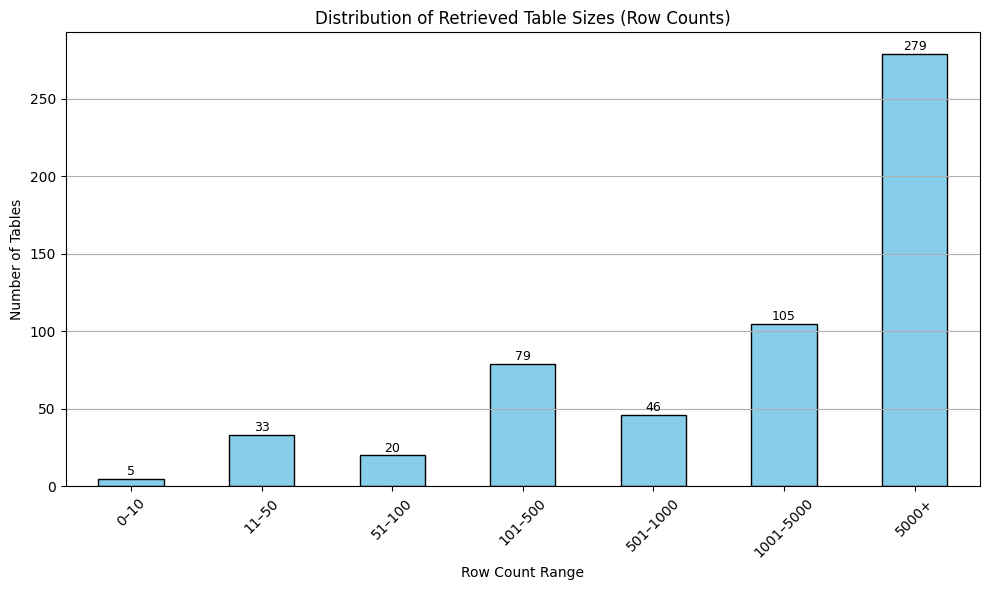

In [110]:
num_tables = len(table_lengths_series)

# Define bins and labels
bins = [0, 10, 50, 100, 500, 1000, 5000, float('inf')]
labels = ["0–10", "11–50", "51–100", "101–500", "501–1000", "1001–5000", "5000+"]

# Bin the data
binned = pd.cut(table_lengths_series, bins=bins, labels=labels, right=True)
binned_counts = binned.value_counts().sort_index()

# Calculate cumulative distribution
cumulative = binned_counts.cumsum() / num_tables * 100  # percent

# Plot bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
binned_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')

# Bar annotations
for i, count in enumerate(binned_counts):
    ax1.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

ax1.set_title("Distribution of Retrieved Table Sizes (Row Counts)")
ax1.set_xlabel("Row Count Range")
ax1.set_ylabel("Number of Tables")
ax1.set_xticklabels(labels, rotation=45)
ax1.grid(axis='y')

plt.tight_layout()
plt.savefig(f"{folder}/table_row_count_distribution.pdf")
plt.show()


### EDA on Columns

##### Column counts across all tables

In [111]:
# Get the number of columns for each table
column_counts = pd.Series({table_id: df.shape[1] for table_id, df in table_data_dfs.items()}, name="num_columns")

# Get descriptive statistics including 90th percentile
column_stats = column_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

# Get the 95th percentile value
p95 = column_stats.loc['95%']

# Count how many tables exceed the 90th percentile
count_above_95th = (column_counts > p95).sum()

print(" Descriptive column stats:\n", column_stats)

total_columns = column_counts.sum()
print(f"\nTotal number of columns across all tables: {total_columns}")
print(f"\nNumber of tables with more than (> {round(p95)} columns): {count_above_95th}")

 Descriptive column stats:
 count    567.000000
mean      35.186949
std       78.414030
min        3.000000
25%        7.000000
50%       11.000000
75%       24.000000
90%       86.800000
95%      152.700000
max      674.000000
Name: num_columns, dtype: float64

Total number of columns across all tables: 19951

Number of tables with more than (> 153 columns): 29


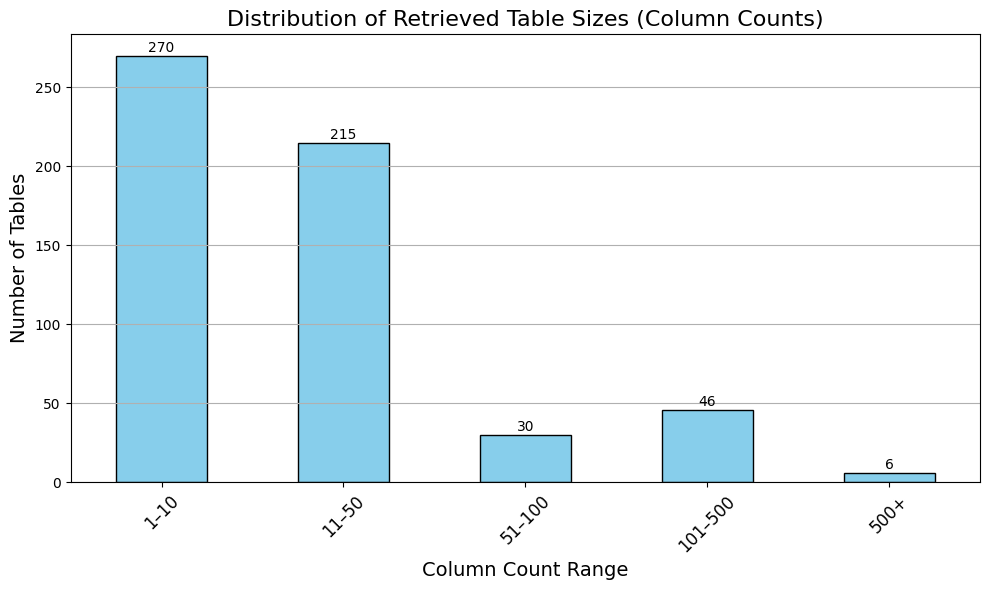

In [112]:
num_tables = len(column_counts)

# Define bins & labels for column counts
bins = [1, 10, 50, 100, 500, float('inf')]
labels = ["1–10", "11–50", "51–100", "101–500", "500+"]

# Bin the column counts
binned_cols = pd.cut(column_counts, bins=bins, labels=labels, right=True)
binned_counts = binned_cols.value_counts().sort_index()

# Calculate cumulative distribution in %
cumulative = binned_counts.cumsum() / num_tables * 100

# Plot bar chart with cumulative line
fig, ax1 = plt.subplots(figsize=(10, 6))
binned_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')

# Bar labels
for i, count in enumerate(binned_counts):
    ax1.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

ax1.set_title("Distribution of Retrieved Table Sizes (Column Counts)", fontsize=16)
ax1.set_xlabel("Column Count Range", fontsize=14)
ax1.set_ylabel("Number of Tables", fontsize=14)
ax1.set_xticklabels(labels, rotation=45, fontsize=12)
ax1.grid(axis='y')

plt.tight_layout()
plt.savefig(f"{folder}/table_column_count_distribution.pdf")
plt.show()


57 tables with more than 85 columns, with some extreme outliers (might be really slow for these cases)

##### Frequency count of column names across all tables
To reduce the number of summaries, one idea is to group columns by their header names across tables. However, even with the same header, the values and surrounding context of that column could differ, leading to different interpretations. So relying only on column names might ignore important differences.

However, it could still be interesting for generalization. If multiple summaries are generated for the same column name, we could try a self-consistency approach by selecting the most frequent one. This might be useful when there's no clear ground truth, like when inferring column types or generating summaries. It's a probably a direction worth exploring if time allows. Or naively generate one to potentially save time and costs.

In [113]:
all_column_names = []
column_types_per_table = {}

for table_id, df in table_data_dfs.items():
    all_column_names.extend(df.columns.astype(str))
    column_types_per_table[table_id] = dict(df.dtypes.astype(str))

    # Count how often each column name appears
column_name_counts = Counter(all_column_names)

common_columns = column_name_counts.most_common()

In [114]:
common_columns[0:25]

[('ID', 567),
 ('Perioden', 532),
 ('Geslacht', 132),
 ('RegioS', 108),
 ('Leeftijd', 78),
 ('BedrijfstakkenBranchesSBI2008', 60),
 ('Marges', 52),
 ('Persoonskenmerken', 32),
 ('WijkenEnBuurten', 21),
 ('Gemeentenaam_1', 19),
 ('SoortRegio_2', 19),
 ('Codering_3', 19),
 ('Herkomstland', 14),
 ('Migratieachtergrond', 13),
 ('Nationaliteit', 13),
 ('BevolkingOp1Januari_1', 12),
 ('IndelingswijzigingWijkenEnBuurten_4', 12),
 ('Kenmerken', 12),
 ('BeroepsEnNietBeroepsbevolking_1', 11),
 ('ParticuliereHuishoudens_1', 11),
 ('KenmerkenVanHuishoudens', 11),
 ('Totaal_1', 10),
 ('LeeftijdOp31December', 10),
 ('GeboortelandOuders', 9),
 ('Regiokenmerken', 9)]

In [115]:
# Count how often each column name appears
column_name_counts = Counter(all_column_names)

# Filter for column names that occur more than once
repeated_columns = {col: count for col, count in column_name_counts.items() if count > 1}

# Total number of such repeated columns
total_repeated_column_headers = len(repeated_columns)

# Total appearances of repeated column names (including duplicates)
total_repeated_column_appearances = sum(repeated_columns.values())

# Total number of columns across all tables
total_columns = sum(column_name_counts.values())

print(f"Total number of columns across all tables: {total_columns}")
print(f"Number of unique column headers that appear in more than one table: {total_repeated_column_headers}")
print(f"Total number of repeated column header appearances across tables: {total_repeated_column_appearances}")


Total number of columns across all tables: 19951
Number of unique column headers that appear in more than one table: 2959
Total number of repeated column header appearances across tables: 9557


##### Column Header Name Lengths

In [116]:
# Initialize lists and dictionaries
all_column_names = []
column_name_lengths = []  # To store lengths of column names
column_types_per_table = {}

# Iterate over all tables
for table_id, df in table_data_dfs.items():
    col_names = df.columns.astype(str)
    all_column_names.extend(col_names)
    column_name_lengths.extend([len(col) for col in col_names])  # Length of each column name
    column_types_per_table[table_id] = dict(df.dtypes.astype(str))

# Basic statistics on column header lengths (rounded)
col_len_series = pd.Series(column_name_lengths, name="column_name_length")
col_len_stats = col_len_series.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).round(2)

print("Column Header Length Stats:\n", col_len_stats)
print(f"\nAverage column header length: {col_len_series.mean():.2f}")
print(f"Max column header length: {col_len_series.max()}")

# If you want to see the longest column names
longest_cols = [(col, len(col)) for col in set(all_column_names)]
longest_cols_sorted = sorted(longest_cols, key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 longest column headers:")
for name, length in longest_cols_sorted:
    print(f"{name} ({length} characters)")


Column Header Length Stats:
 count    19951.00
mean        21.02
std          9.71
min          2.00
25%         13.00
50%         21.00
75%         29.00
90%         35.00
95%         37.00
max         42.00
Name: column_name_length, dtype: float64

Average column header length: 21.02
Max column header length: 42

Top 10 longest column headers:
OnderwijsvoorzieningenJonggehandicapten_10 (42 characters)
OnderwijsvoorzieningenJonggehandicapten_33 (42 characters)
TotaalWerkelijkeIndividueleConsumptie_203 (41 characters)
BetaaldeInkomensoverdrachtenBuitenland_82 (41 characters)
AfvoerAfvalLuchtzuiveringsinstallaties_36 (41 characters)
TotaalArbeidsongeschiktheidsuitkeringen_1 (41 characters)
OpkweekmateriaalBloemkwekerijgewassen_399 (41 characters)
PersonenFrauduleuzeBerichtenOntvangen_168 (41 characters)
FunctieroulatieDetacheringStudiebezoek_31 (41 characters)
GezondheidszorgInternationaleDefinitie_18 (41 characters)


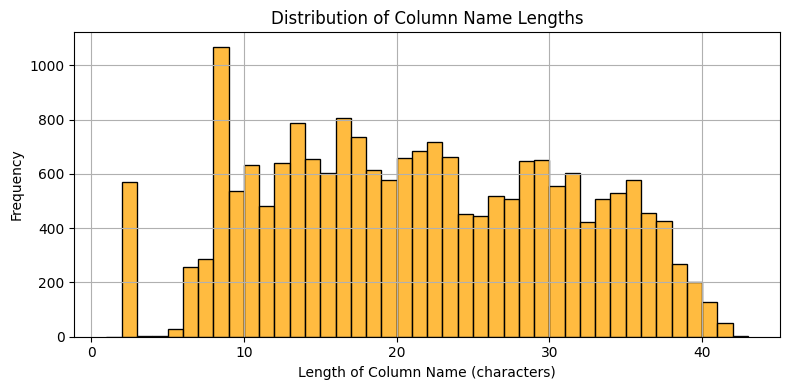

In [117]:
plt.figure(figsize=(8, 4))
sns.histplot(column_name_lengths, bins=range(1, max(column_name_lengths)+2), kde=False, color="orange")
plt.title("Distribution of Column Name Lengths")
plt.xlabel("Length of Column Name (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


# Preprocess Data + some additional EDA

## Helper functions

### Cleaning Text and Columns for BM25

Data Cleaning helper functions needed to stringify the tables dataset itself, and tokenizer for bm25

In [118]:
def clean_text_string(text):
    if isinstance(text, str):
        return text.replace('\n', ' ').strip()
    return text  # leave unchanged if not a string

def clean_text_column(df, column_name):
    df[column_name] = df[column_name].apply(clean_text_string)
    return df

def safe_eval_keywords(x):
    return ast.literal_eval(x) if pd.notnull(x) else []

def combine_metadata_fields(row, columns=None):
    """
    Concatenate selected fields from a DataFrame row into a single string.

    Args:
        row (pd.Series): A row from a DataFrame.
        columns (list): List of column names to concatenate. If None, all columns are used by default.

    Returns:
        str: Concatenated string of the metadata.
    """
    if columns is None:
        columns = row.index  # Use all columns if none specified

    pieces = []
    for col in columns:
        value = row[col]

        if isinstance(value, list):
            pieces.append(' '.join(map(str, value)))
        elif pd.notnull(value):
            pieces.append(str(value))

    return ' '.join(pieces).strip()



### Preprocessing for BM25

BM25 expects a specific token format (where tokens are just words, as exact term matching is performed)

We preprocessing these tokens as follows: lowercasing & non alphanumeric from metadata columns (excl table id)
Could make reflections on normalization gain and potential information loss due to ambiguity (i.e. Apple the brand vs apple the fruit)

note Spacy too much overhead, regex same result for our usecase

In [119]:
def tokenize_text(text):
    """

    Args:
    - text (str): The text to be cleaned.

    Returns:
    - list: A list of cleaned, tokenized words.
    """
    # Remove non-alphanumeric characters (keeping spaces)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Convert to lowercase to normalize the text
    cleaned_text = cleaned_text.lower()

    # Tokenize by splitting on spaces (this will now give full words)
    tokens = cleaned_text.split()

    return tokens

# # Enable Spacy GPU before loading the model
# activated = spacy.prefer_gpu()
# # Load Dutch model once
# nlp = spacy.load("nl_core_news_sm")

# def spacy_tokenizer(text: str) -> List[str]:
#     """
#     Tokenize Dutch text using spaCy.
#     Clean and tokenize text by removing non-alphanumeric characters and converting to lowercase.


#     Args:
#         text (str): Input string.

#     Returns:
#         List[str]: Token list.
#     """
#     doc = nlp(text)
#     return [token.text.lower() for token in doc if not token.is_punct and not token.is_space]

# #Testing, regex LGTM, spacy = overkill

# dutch_text = """
# In dit onderzoek analyseren we de gegevens van verschillende tabellen die afkomstig zijn van open overheidsdatabronnen.
# Elke tabel bevat kolomnamen zoals ["Gemeente", "Bevolking", "Inkomen per huishouden", "Jaar"].
# De bedoeling is om inzicht te krijgen in hoe Nederlandse gemeenten verschillen op basis van sociaaleconomische factoren.

# Daarnaast willen we kijken naar trends over tijd. Bijvoorbeeld, hoe heeft het gemiddeld inkomen per huishouden zich ontwikkeld tussen 2010 en 2020?
# Hiervoor gebruiken we kolommen als ["Jaar", "Gemiddeld Inkomen", "Huishoudenstype"].

# Het is belangrijk om dubbele kolomnamen correct te interpreteren, vooral als de waarden qua context verschillen.
# Sommige datasets gebruiken de kolom "Inkomen" om bruto-inkomen aan te duiden, terwijl andere "Inkomen" bedoelen als netto-inkomen.

# Verder bevat elke tabel rijen met gegevens, zoals:
# ["Amsterdam", 872757, 42000, 2020]
# ["Rotterdam", 651157, 37000, 2020]

# Deze data wordt vervolgens geschoond, getokenized en verwerkt met behulp van BM25 om de relevantste tabellen te vinden bij een gebruikersvraag.
# """

# spacy_tokenizer(dutch_text)
# tokenize_text(dutch_text)

### Concatinating Original Metadata

In [120]:
columns_to_concat = ['table_desc', 'expanded_desc', 'Keywords', 'Summary']

def clean_and_concat(row, columns_to_concat):
    """Clean selected columns by removing all \\n and \n and reducing whitespace to single space."""
    pattern_newlines = re.compile(r'(\\n|\n)+')
    pattern_whitespace = re.compile(r'\s+')

    cleaned_parts = []
    for col in columns_to_concat:
        # Convert to string, replace newlines with space
        cleaned = pattern_newlines.sub(' ', str(row[col]))
        # Reduce multiple whitespace chars to a single space
        cleaned = pattern_whitespace.sub(' ', cleaned).strip()
        cleaned_parts.append(cleaned)

    return ' '.join(cleaned_parts)

In [121]:
df_tables['original_metadata_text'] = df_tables.apply(
    lambda row: clean_and_concat(row, columns_to_concat),
    axis=1
)

In [122]:
# df_tables['original_metadata_text'][0]

## CENTRALIZED dataframe of tables Metadata + Table Schema Data (Flattened) to create docs

In [123]:
# Step 1: Get formatted data
formatted_tables

# Step 2: Convert the result to a DataFrame
info_df = pd.DataFrame.from_dict(formatted_tables, orient='index')
info_df.reset_index(inplace=True)
info_df.rename(columns={'index': 'table_id'}, inplace=True)

# Step 3: Merge with df_tables on 'table_id'
new_columns = ['raw_columns_string', 'columns_string', 'column_samples_string', 'example_rows_string']
if not all(col in df_tables.columns for col in new_columns):
    df_tables = df_tables.merge(info_df, on='table_id', how='left')

### EDA Original metadata text length

In [124]:
df_tables.head()

,table_id,table_desc,expanded_desc,Keywords,Summary,original_metadata_text,raw_columns_string,columns_string,column_samples_string,example_rows_string
0,70072ned,Regionale kerncijfers Nederland \nIn deze tabe...,Regionale kerncijfers Nederland,"['Regionale kerncijfers Nederland', 'oud papie...",Deze tabel kan geraadpleegd worden indien gege...,Regionale kerncijfers Nederland In deze tabel ...,ID | RegioS | Perioden | TotaleBevolking_1 | M...,I D | Regio S | Perioden | Totale Bevolking | ...,"ID: [7188, 5781, 8299] | RegioS: ['GM1774', 'G...",ID: 6312 | RegioS: 'GM1719' | Perioden: '2007J...
1,60048ned,Verhuisde personen; regio \nDeze tabel bevat g...,"Verhuisde personen; binnen gemeenten, tussen r...","['Verhuisde personen', 'binnen gemeenten', 'tu...",Deze tabel kan geraadpleegd worden indien men ...,Verhuisde personen; regio Deze tabel bevat geg...,ID | RegioS | Perioden | BinnenGemeentenVerhui...,I D | Regio S | Perioden | Binnen Gemeenten Ve...,"ID: [608, 4179, 713] | RegioS: ['GM1876', 'GM0...",ID: 6312 | RegioS: 'GM1876' | Perioden: '2000J...
2,85539NED,SES-WOA scores per wijk en buurt \nDeze tabel ...,Sociaal-economische status; scores per wijk en...,"['Sociaal-economische status', 'scores', 'wijk...",Deze tabel kan geraadpleegd worden indien men ...,SES-WOA scores per wijk en buurt Deze tabel be...,ID | WijkenEnBuurten | Perioden | RegiocodeGem...,I D | Wijken En Buurten | Perioden | Regiocode...,"ID: [811, 1917, 3389] | WijkenEnBuurten: ['BU0...",ID: 6312 | WijkenEnBuurten: 'BU04847015' | Per...
3,80783ned,"Landbouw; hoofdbedrijfstype, regio \nDeze tabe...","Landbouw; gewassen, dieren en grondgebruik naa...","['Landbouw', 'Gewassen', 'Dieren', 'Grondgebru...",Deze tabel kan geraadpleegd worden indien men ...,"Landbouw; hoofdbedrijfstype, regio Deze tabel ...",ID | Bedrijfstypen | RegioS | Perioden | Aanta...,I D | Bedrijfstypen | Regio S | Perioden | Aan...,"ID: [9747, 5218, 3448] | Bedrijfstypen: ['A009...",ID: 6312 | Bedrijfstypen: 'A009481' | RegioS: ...
4,85163NED,SES-WOA scores per wijk en buurt \nDeze tabel ...,Sociaal-economische status; scores per wijk en...,"['Sociaal-economische status', 'Wijk en buurt'...",Deze tabel kan geraadpleegd worden indien men ...,SES-WOA scores per wijk en buurt Deze tabel be...,ID | WijkenEnBuurten | Perioden | RegiocodeGem...,I D | Wijken En Buurten | Perioden | Regiocode...,"ID: [685, 2619, 8844] | WijkenEnBuurten: ['BU1...",ID: 6312 | WijkenEnBuurten: 'WK036315 ' | Per...


In [125]:
# Get character lengths
text_lengths = df_tables['original_metadata_text'].str.len()

# Get summary statistics on character length
summary_stats = text_lengths.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

# Print nicely
print("Original Metadata Character Length Stats:\n", summary_stats.round(2))

Original Metadata Character Length Stats:
 count     494.00
mean     2324.55
std       996.81
min       922.00
10%      1353.90
25%      1616.75
50%      2111.50
75%      2756.00
90%      3347.30
95%      4105.80
max      7135.00
Name: original_metadata_text, dtype: float64


Character Length Statistics for column 'original_metadata_text':
 count     494.00
mean     2324.55
std       996.81
min       922.00
10%      1353.90
25%      1616.75
50%      2111.50
75%      2756.00
90%      3347.30
95%      4105.80
max      7135.00
Name: original_metadata_text, dtype: float64
Plot exported as image to original_metadata_length.pdf


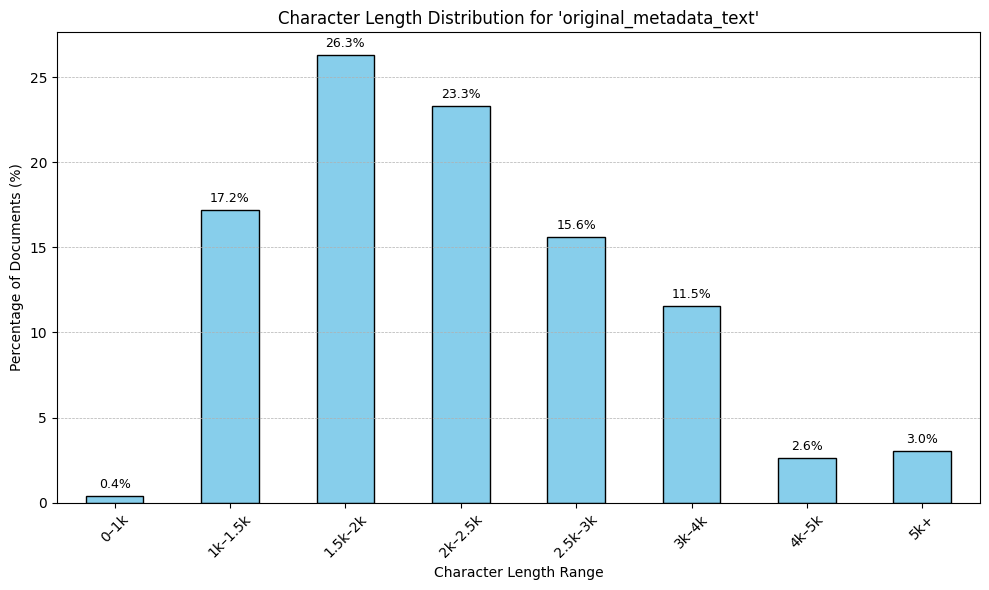

In [126]:
def analyze_text_lengths_log(df, column='original_metadata_text', plot=True, export_name=None):
    """
    Analyzes character lengths of text data in a given column of a DataFrame,
    and plots a binned distribution without log-scaled y-axis.
    Optionally exports the plot as an image file.

    Args:
        df (pd.DataFrame): The DataFrame containing the text data.
        column (str): The column name with the text data.
        plot (bool): Whether to plot a binned distribution of character lengths.
        export_path (str or None): File path to export the plot as an image (png, jpg, etc.).
                                   If None, plot is shown but not saved.

    Returns:
        pd.Series: Series of character lengths.
    """
    # Compute character lengths
    text_lengths = df[column].str.len()

    # Summary statistics
    summary_stats = text_lengths.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
    print(f"Character Length Statistics for column '{column}':\n", summary_stats.round(2))

    if plot:
        # Define bins and labels
        bins = [0, 1000, 1500, 2000, 2500, 3000, 4000, 5000, float('inf')]
        labels = ["0–1k", "1k–1.5k", "1.5k–2k", "2k–2.5k", "2.5k–3k", "3k–4k", "4k–5k", "5k+"]

        # Bin and count
        binned = pd.cut(text_lengths, bins=bins, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

        # Convert counts to percentages
        relative_freq = binned_counts / binned_counts.sum() * 100

        # Plot
        plt.figure(figsize=(10, 6))
        relative_freq.plot(kind='bar', color='skyblue', edgecolor='black')

        for i, count in enumerate(relative_freq):
            plt.text(i, count + 0.3, f"{count:.1f}%", ha='center', va='bottom', fontsize=9)

        plt.title(f"Character Length Distribution for '{column}'")
        plt.xlabel("Character Length Range")
        plt.ylabel("Percentage of Documents (%)")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        if export_name:
            plt.savefig(f"{folder}/{export_name}.pdf")
            print(f"Plot exported as image to {export_name}.pdf")
            plt.show()
            plt.close()
        else:
            plt.show()

    return text_lengths


char_lengths = analyze_text_lengths_log(df_tables, column='original_metadata_text', export_name="original_metadata_length")


### Rough estimated LLM tokens (i.e. minimum context length required for generating a column summary)
From https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
Other model and language, but ballpark estimate but nonetheless to estimate job duration

In [127]:
# Step 1: Compute text lengths
text_lengths = df_tables['original_metadata_text'].str.len()

# Step 2: Rough token estimation (1 token ≈ 4 characters)
estimated_tokens = text_lengths / 4

# Step 4: Describe the estimated token stats
token_stats = estimated_tokens.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

# Step 5: Print it nicely
print("Rough Estimated Token Stats:\n", token_stats.round(2))

Rough Estimated Token Stats:
 count     494.00
mean      581.14
std       249.20
min       230.50
10%       338.48
25%       404.19
50%       527.88
75%       689.00
90%       836.82
95%      1026.45
max      1783.75
Name: original_metadata_text, dtype: float64


#### Approx worst case context length for 2nd phase end table summary (4char/token):
llama 3.1 max context length 128k

max_generated_tokens(512) * max columns + prompt

In [128]:
adjusted = 128 * column_counts.max() + 200
worst = 512 * column_counts.max() + 200
print(f"Token generation required (fall back method): {adjusted}")
print(f"Token generation required (current implementation): {worst}")

Token generation required (fall back method): 86472
Token generation required (current implementation): 345288


#### Missing data (Summary of missing data for each table in each column

In [129]:
missing_summary = {}

for table_id, df in table_data_dfs.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_summary[table_id] = missing[missing > 0].to_dict()


#### Data types of Tables
Since the table data is retrieved as JSON from the API, original data types are lost and only inferred upon loading. This makes data type based EDA unreliable and should be interpreted cautiously.

In [130]:
# dtype_summary = {"object": 0, "int": 0, "float": 0, "bool": 0, "other": 0}

# for df in table_data_dfs.values():
#     for dtype in df.dtypes:
#         t = str(dtype)
#         if "int" in t:
#             dtype_summary["int"] += 1
#         elif "float" in t:
#             dtype_summary["float"] += 1
#         elif "bool" in t:
#             dtype_summary["bool"] += 1
#         elif t == "object":
#             dtype_summary["object"] += 1
#         else:
#             dtype_summary["other"] += 1

# # dtype_summary

In [131]:
# column_value_stats = {}

# for table_id, df in table_data_dfs.items():
#     stats = {}
#     for col in df.columns:
#         col_data = df[col]
#         stats[col] = {
#             "dtype": str(col_data.dtype),
#             "n_unique": col_data.nunique(),
#             "most_common": col_data.value_counts().head(3).to_dict()
#         }
#     column_value_stats[table_id] = stats
# column_value_stats

## Experiment Results (Granular) LLM summary generation
Our approach leverages intermediate token generations to build summaries, mimicking the LLM’s "reasoning" process. We break the summarization task into smaller subtasks to produce a more representative description of each table, essentially as an attempt to divert from standard greedy decoding and its token distribution biases (also by setting the model parameters to deviate from greedy decoding). Inspired by self-consistency methods, we generate stepwise summaries of table contents and aggregate them into a final summary, aiming for a more accurate representation to support document expansion and information retrieval.

todo if time allows explore and evaluate the initial column summary phase

In [132]:
import pandas as pd
df_CSummary_TS = pd.DataFrame.from_dict(llama_CSSummary_TS, orient='index')
df_CSample_TS = pd.DataFrame.from_dict(llama_CSample_TS, orient='index')
df_Column_TS = pd.DataFrame.from_dict(llama_Column_TS, orient='index')

In [180]:
df_Column_TS['original_metadata_text'][3]

/tmp/ipython-input-180-2291733640.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_Column_TS['original_metadata_text'][3]


"Huwen; kerncijfers Deze tabel bevat kerncijfers over huwelijkssluitingen en partnerschappen onder de bevolking van Nederland. In de tabel zijn de gegevens uit te splitsen naar de volgende kenmerken: - Huwelijkssluitingen naar wederzijds geslacht; - Huwende personen naar geslacht en burgerlijke staat; - Gemiddelde leeftijd bij huwelijkssluiting naar geslacht en burgerlijke staat; - Gemiddeld aantal gesloten huwelijken per persoon naar geslacht; - Partnerschapsregistraties naar wederzijds geslacht. Gegevens beschikbaar vanaf: 1950 Status van de cijfers: Alle in de tabel opgenomen cijfers zijn definitieve cijfers. Wijzigingen per 13 juli 2023: De cijfers over 2022 zijn toegevoegd. Wanneer komen er nieuwe cijfers? In het 2e kwartaal van 2024 worden de definitieve cijfers over 2023 in deze publicatie opgenomen. Huwelijkssluitingen tussen paren van gelijk en verschillend geslacht partnerschappen en huwende personen Huwen en partnerschapsregistraties; kerncijfers ['huwen', 'partnerschapsregi

In [181]:
import pandas as pd

lst = df_Column_TS['original_metadata_text'][3] # your list with math strings

series = pd.Series(lst)

latex_code = series.to_latex(index=False, header=True)
print(latex_code)



\begin{tabular}{l}
\toprule
0 \\
\midrule
Huwen; kerncijfers Deze tabel bevat kerncijfers over huwelijkssluitingen en partnerschappen onder de bevolking van Nederland. In de tabel zijn de gegevens uit te splitsen naar de volgende kenmerken: - Huwelijkssluitingen naar wederzijds geslacht; - Huwende personen naar geslacht en burgerlijke staat; - Gemiddelde leeftijd bij huwelijkssluiting naar geslacht en burgerlijke staat; - Gemiddeld aantal gesloten huwelijken per persoon naar geslacht; - Partnerschapsregistraties naar wederzijds geslacht. Gegevens beschikbaar vanaf: 1950 Status van de cijfers: Alle in de tabel opgenomen cijfers zijn definitieve cijfers. Wijzigingen per 13 juli 2023: De cijfers over 2022 zijn toegevoegd. Wanneer komen er nieuwe cijfers? In het 2e kwartaal van 2024 worden de definitieve cijfers over 2023 in deze publicatie opgenomen. Huwelijkssluitingen tussen paren van gelijk en verschillend geslacht partnerschappen en huwende personen Huwen en partnerschapsregistraties;

/tmp/ipython-input-181-3825108408.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lst = df_Column_TS['original_metadata_text'][3] # your list with math strings


AttributeError: 'str' object has no attribute 'to_latex'

In [ ]:
# df_CSummary_TS['overall_summary'][0]

In [ ]:
# len(df_CSummary_TS['overall_summary'][0]) / 4

Filter out the tables that did not have a metadata should be 73

In [ ]:
count = (df_CSummary_TS['original_metadata_text'] == 'Niet Beschikbaar.').sum()
print(f"Count: {count}")

In [ ]:
# Convert to sets
ids_metadata = set(df_Column_TS['table_id'])
ids_qa = set(df_qa['table_id'])

# Check overlap
intersection = ids_metadata.intersection(ids_qa)
missing_in_qa = ids_metadata - ids_qa
print(f"Tables missing in experiments: {len(ids_metadata)}")

We remove the tables that did not have an original metadata

In [ ]:
qa_table_ids = set(df_qa['table_id'].astype(str))

df_CSummary_TS = df_CSummary_TS[df_CSummary_TS.index.astype(str).isin(qa_table_ids)].copy()
df_CSample_TS = df_CSample_TS[df_CSample_TS.index.astype(str).isin(qa_table_ids)].copy()
df_Column_TS = df_Column_TS[df_Column_TS.index.astype(str).isin(qa_table_ids)].copy()

In [ ]:
ids_metadata = set(df_Column_TS['table_id'])
ids_qa = set(df_qa['table_id'])

# Check overlap
intersection = ids_metadata.intersection(ids_qa)
missing_in_qa = ids_metadata - ids_qa
print(f"Tables missing in experiments: {len(ids_metadata)}")

### Concatonated raw metadata text

In [ ]:
cols_original = [
    "table_desc",
    "expanded_desc",
    "Summary",
    "Keywords",
    "columns_string"
]

col_CSummary_TSummary = [
    "original_metadata_text",
    "overall_summary",
    # "schema_summary"
]

col_CSample_TSummary = [
    "original_metadata_text",
    "table_w_sample_summary",
    # "schema_summary"
]

col_Column_TSummary = [
    "original_metadata_text",
    "table_flatten_only_summary",
    # "schema_summary"
]


In [ ]:
df_CSummary_TS.head()

This would be similar to pneumas paper conc_column_summaries, but we combine row and col summaries into one step and dont rely on metadata generation (with datasheet qa) if no is available, instead we eval only with metadata that was readilyu available and will use that as gt


In [ ]:
df_CSummary_TS['conc_column_summaries'] = df_CSummary_TS['column_summaries'].apply(lambda x: ' | '.join(x))

In [ ]:
# Total text length
total_length = df_CSummary_TS['conc_column_summaries'].str.len().sum()

# Average text length
average_length = df_CSummary_TS['conc_column_summaries'].str.len().mean()

print("Total text length:", total_length)
print("Average text length:", average_length)


In [ ]:
# Total text length
total_length = df_CSummary_TS['overall_summary'].str.len().sum()

# Average text length
average_length = df_CSummary_TS['overall_summary'].str.len().mean()

print("Total text length:", total_length)
print("Average text length:", average_length)


In [ ]:
df_CSummary_TS.head()

In [ ]:
# GEN_col_CSummary_TSummary = ['overall_summary'] # Experiment table summaries
GEN_col_CSummary_TSummary = ['conc_column_summaries'] # Retrieval evaluation on all generated summaries (similar to pneuma)
GEN_col_CSample_TSummary = ['table_w_sample_summary']
GEN_col_Column_TSummary = ['table_flatten_only_summary']

Clean GENERATED TABLE metadata only

In [ ]:
# GEN_col_CSummary_TSummary = ['overall_summary']
# GEN_col_CSample_TSummary = ['table_w_sample_summary']
# GEN_col_Column_TSummary = ['table_flatten_only_summary']

In [ ]:
df_Column_TS

In [ ]:
df_CSummary_TS['GEN_CSummary_metadata_text'] = df_CSummary_TS.apply(
    lambda row: clean_and_concat(row, GEN_col_CSummary_TSummary),
    axis=1
)

df_CSample_TS['GEN_CSample_metadata_text'] = df_CSample_TS.apply(
    lambda row: clean_and_concat(row, GEN_col_CSample_TSummary),
    axis=1
)

df_Column_TS['GEN_Column_metadata_text'] = df_Column_TS.apply(
    lambda row: clean_and_concat(row, GEN_col_Column_TSummary),
    axis=1
)

In [ ]:
df_CSummary_TS['GEN_CSummary_metadata_text'][0]

Concatonated Metadata + generated metadata

In [ ]:
df_CSummary_TS['CSummary_metadata_text'] = df_CSummary_TS.apply(
    lambda row: clean_and_concat(row, col_CSummary_TSummary),
    axis=1
)

df_CSample_TS['CSample_metadata_text'] = df_CSample_TS.apply(
    lambda row: clean_and_concat(row, col_CSample_TSummary),
    axis=1
)

df_Column_TS['Column_metadata_text'] = df_Column_TS.apply(
    lambda row: clean_and_concat(row, col_Column_TSummary),
    axis=1
)

In [ ]:
df_CSummary_TS['overall_summary'][0]

In [ ]:
df_CSummary_TS['CSummary_metadata_text'][0]

In [ ]:
df_CSummary_TS['original_metadata_text'][0]

## Prepare data as docs for bm25

In [ ]:
def prepare_metadata_tokens_bm25(metadata_df, metadata_cols):
    def combine_and_tokenize(row):
        # Use only columns that exist
        valid_cols = [col for col in metadata_cols if col in row.index]
        combined = " ".join(str(row[col]) for col in valid_cols)
        return tokenize_text(combined)

    result_df = metadata_df.copy()
    result_df['tokenized_metadata'] = result_df.apply(combine_and_tokenize, axis=1)
    result_df['table_id'] = result_df['table_id'].astype(str)

    return result_df[['table_id', 'tokenized_metadata']]

# For original columns
metadata_tokens_original = prepare_metadata_tokens_bm25(df_tables, cols_original)

# For overall + schema summary
metadata_tokens_CSummary_TSummary = prepare_metadata_tokens_bm25(df_CSummary_TS, col_CSummary_TSummary)

# For sample summary + schema summary
metadata_tokens_CSample_TSummary = prepare_metadata_tokens_bm25(df_CSample_TS, col_CSample_TSummary)

# For flattened summary + schema summary
metadata_tokens_Column_TSummary = prepare_metadata_tokens_bm25(df_Column_TS, col_Column_TSummary)


## GENERATED METADATA ONLY
GEN_metadata_tokens_CSummary_TSummary = prepare_metadata_tokens_bm25(df_CSummary_TS, GEN_col_CSummary_TSummary)
GEN_metadata_tokens_CSample_TSummary = prepare_metadata_tokens_bm25(df_CSample_TS, GEN_col_CSample_TSummary)
GEN_metadata_tokens_Column_TSummary = prepare_metadata_tokens_bm25(df_Column_TS, GEN_col_Column_TSummary)

In [ ]:
GEN_metadata_tokens_Column_TSummary

### Generated Metadata Length

In [ ]:
# Analyze combined metadata text lengths for CSummary
char_lengths_CSummary = analyze_text_lengths_log(df_CSummary_TS, column='GEN_CSummary_metadata_text', export_name='GEN_CSummary_metadata_length')

# Analyze combined metadata text lengths for CSample
char_lengths_CSample = analyze_text_lengths_log(df_CSample_TS, column='GEN_CSample_metadata_text', export_name='GEN_CSample_metadata_length')

# Analyze combined metadata text lengths for Column summary
char_lengths_Column = analyze_text_lengths_log(df_Column_TS, column='GEN_Column_metadata_text', export_name='GEN_Column_metadata_length')


### Original + Generated Metadata Length

In [ ]:
# Analyze original metadata text lengths
char_lengths_original = analyze_text_lengths_log(df_tables, column='original_metadata_text', export_name='original_metadata_length')

# Analyze combined metadata text lengths for CSummary
char_lengths_CSummary = analyze_text_lengths_log(df_CSummary_TS, column='CSummary_metadata_text', export_name='CSummary_metadata_length')

# Analyze combined metadata text lengths for CSample
char_lengths_CSample = analyze_text_lengths_log(df_CSample_TS, column='CSample_metadata_text', export_name='CSample_metadata_length')

# Analyze combined metadata text lengths for Column summary
char_lengths_Column = analyze_text_lengths_log(df_Column_TS, column='Column_metadata_text', export_name='Column_metadata_length')


### Mapping Doc ID to Table ID for evaluation
While the data is seeded and pipelined, we separate here to ensue independence

In [ ]:
# Then extract lists as needed

def map_docid_tableid(docs):
    return docs['tokenized_metadata'].tolist(), docs['table_id'].tolist()

docs_original, table_ids_original = map_docid_tableid(metadata_tokens_original)
docs_CSummary, table_ids_CSummary = map_docid_tableid(metadata_tokens_CSummary_TSummary)
docs_CSample, table_ids_CSample = map_docid_tableid(metadata_tokens_CSample_TSummary)
docs_Column, table_ids_Column = map_docid_tableid(metadata_tokens_Column_TSummary)


GEN_docs_CSummary, GEN_table_ids_CSummary = map_docid_tableid(GEN_metadata_tokens_CSummary_TSummary)
GEN_docs_CSample, GEN_table_ids_CSample = map_docid_tableid(GEN_metadata_tokens_CSample_TSummary)
GEN_docs_Column, GEN_table_ids_Column = map_docid_tableid(GEN_metadata_tokens_Column_TSummary)

## Prepping metadata for ColBERT

In [ ]:
# def prepare_colbert_metadata_dataframe(df_tables):
#     df = df_tables.copy()

#     # Clean the text columns
#     for col in ['table_desc', 'expanded_desc', 'Summary']:
#         df = clean_text_column(df, col)

#     # Clean the keywords list
#     df['Keywords'] = df['Keywords'].apply(safe_eval_keywords)

#     metadata_cols = ["table_desc", "expanded_desc", "Summary", "Keywords", "columns_string"]

#     # Apply the combine function with selected columns
#     df['full_metadata'] = df.apply(lambda row: combine_metadata_fields(row, columns=metadata_cols), axis=1)

#     # Final output
#     metadata_df_colbert = df[['table_id', 'full_metadata']].set_index('table_id')

#     return metadata_df_colbert


def prepare_metadata_for_colbert(df, metadata_cols):
    """
    Prepares tokenized metadata for ColBERT by combining and cleaning selected columns.

    Args:
        df (pd.DataFrame): DataFrame containing table metadata.
        metadata_cols (list): List of column names to include in the metadata string.

    Returns:
        pd.DataFrame: A DataFrame with 'table_id' as index and 'full_metadata' column.
    """
    df = df.copy()
    df['full_metadata'] = df.apply(lambda row: clean_and_concat(row, metadata_cols), axis=1)
    df['table_id'] = df['table_id'].astype(str)

    return df[['table_id', 'full_metadata']].set_index('table_id')


In [ ]:
# colbert_metadata = prepare_colbert_metadata_dataframe(df_tables)
colbert_metadata_original = prepare_metadata_for_colbert(df_tables, cols_original)
colbert_metadata_CSummary_TSummary = prepare_metadata_for_colbert(df_CSummary_TS, col_CSummary_TSummary)
colbert_metadata_CSample_TSummary = prepare_metadata_for_colbert(df_CSample_TS, col_CSample_TSummary)
colbert_metadata_Column_TSummary = prepare_metadata_for_colbert(df_Column_TS, col_Column_TSummary)

GEN_colbert_metadata_CSummary_TSummary = prepare_metadata_for_colbert(df_CSummary_TS, GEN_col_CSummary_TSummary)
GEN_colbert_metadata_CSample_TSummary = prepare_metadata_for_colbert(df_CSample_TS, GEN_col_CSample_TSummary)
GEN_colbert_metadata_Column_TSummary = prepare_metadata_for_colbert(df_Column_TS, GEN_col_Column_TSummary)

In [ ]:
# GEN_colbert_metadata_CSummary_TSummary['full_metadata'][table_id == 37201]

In [ ]:
GEN_colbert_metadata_Column_TSummary.iloc[0]

##### Queries to search for colbert

In [ ]:
# Metadata into Doc List
colbert_queries = df_qa['Query'].tolist()

# Table ID List ground truth for eval later
colbert_table_ids_groundtruth = df_qa['table_id'].tolist()

# EXPERIMENTS

## Retrieval Eval (baseline, sparse retrieval method): BM25

### Creating bm25 instance from the data

In [ ]:
# # Create BM25 models for each set
# bm25_original = BM25Okapi(docs_original)
# bm25_CSummary = BM25Okapi(docs_CSummary)
# bm25_CSample = BM25Okapi(docs_CSample)
# bm25_Column = BM25Okapi(docs_Column)

GEN_bm25_CSummary = BM25Okapi(GEN_docs_CSummary)
# GEN_bm25_CSample = BM25Okapi(GEN_docs_CSample)
# GEN_bm25_Column = BM25Okapi(GEN_docs_Column)


In [ ]:
GEN_docs_CSample[0]

### BM25 evaluation pipeline {P, R, F1}@k

In [ ]:
def run_bm25_retrieval(query_df: pd.DataFrame, bm25, table_ids: List[str], tokenize_func) -> List[Dict]:
    """
    Runs BM25 retrieval for each query and returns the top table IDs and scores.
    """
    retrieval_results = []

    for _, row in query_df.iterrows():
        query_text = row['Query']
        query_tokens = tokenize_func(query_text)
        true_id = str(row['table_id'])

        scores = bm25.get_scores(query_tokens)
        top_indices = np.argsort(scores)[::-1]  # Sort descending
        top_table_ids = [table_ids[i] for i in top_indices]
        top_scores = [scores[i] for i in top_indices]

        retrieval_results.append({
            'query': query_text,
            'true_table_id': true_id,
            'top_table_ids': top_table_ids,
            'top_scores': top_scores
        })

    return retrieval_results


def evaluate_top_k(retrieval_results: List[Dict], k_values: List[int]) -> Dict[int, Dict[str, float]]:
    """
    Evaluates precision, recall, and F1-score at each k.
    """
    metrics_by_k = {}

    total_queries = len(retrieval_results)

    for k in k_values:
        correct_retrievals = 0
        precision_list = []

        for result in retrieval_results:
            top_k = result['top_table_ids'][:k] # top k retrieved documents
            is_relevant = result['true_table_id'] in top_k # check if ground truth relevant doc is in top k

            correct_retrievals += int(is_relevant) # count for total correct retrieval
            precision_list.append(int(is_relevant) / k) # precision = relevant doc / retrieved doc

        precision = np.mean(precision_list) # average precision
        recall = correct_retrievals / total_queries # average relevant docs retrieved / all relevant docs, each query has either 0/1 or 1/1 relevant retrieved docs retrieved
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics_by_k[k] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
        }

        print(f"\nTop-{k} Evaluation:")
        print(f"Precision@{k}: {precision:.2f}")
        print(f"Recall@{k}:    {recall:.2f}")
        print(f"F1 Score@{k}:  {f1:.2f}")

    return metrics_by_k


def evaluate_bm25_top_k(query_df: pd.DataFrame, bm25, table_ids: List[str], k_values: List[int] = [1, 3, 5, 10],
                        tokenize_func=tokenize_text) -> Tuple[Dict[int, Dict[str, float]], pd.DataFrame]:
    """
    Main evaluation wrapper.
    """
    retrieval_results = run_bm25_retrieval(query_df, bm25, table_ids, tokenize_func)
    metrics_by_k = evaluate_top_k(retrieval_results, k_values)
    results_df = pd.DataFrame(retrieval_results)

    return metrics_by_k, results_df


### Evaluation of top k

In [ ]:
k_vals = [1, 2, 3, 5, 10]

models = {
    'original': (bm25_original, table_ids_original),
    'CSummary': (bm25_CSummary, table_ids_CSummary),
    'CSample': (bm25_CSample, table_ids_CSample),
    'Column': (bm25_Column, table_ids_Column),
}

results = {}

for name, (bm25_model, table_ids) in models.items():
    print(f"\nEvaluating BM25 model: {name}")
    start = time.time()
    metrics, result_df = evaluate_bm25_top_k(query_df=df_qa, bm25=bm25_model, table_ids=table_ids, k_values=k_vals)
    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")
    print("Metrics:", metrics)
    results[name] = (metrics, result_df)




# Prepare a list to accumulate rows
rows = []

for name, (metrics, _) in results.items():
    for k, vals in metrics.items():
        row = {'Model': name, 'k': k}
        row.update(vals)  # assuming vals is a dict of metric_name: value
        rows.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(rows)




# You can export with nice formatting (float precision, captions, etc.)
latex_table = results_df.to_latex(index=False, float_format="%.3f",
                                  caption="BM25 Evaluation Metrics across Models and Top-K values",
                                  label="tab:bm25_metrics")

# Save to a .tex file
with open(f"{folder}bm25_metrics_table.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table exported to bm25_metrics_table.tex")


In [ ]:
print(latex_table)

eval for generated summaries only (without original metadata)

In [ ]:
from tqdm import tqdm
!pip install tqdm

In [ ]:
k_vals = [1, 2, 3, 5, 10]


# models = {
#     'original': (bm25_original, table_ids_original),
#     'GEN_CSummary': (GEN_bm25_CSummary, GEN_table_ids_CSummary),
#     'GEN_CSample': (GEN_bm25_CSample, GEN_table_ids_CSample),
#     'GEN_Column': (GEN_bm25_Column, GEN_table_ids_Column),
# }

# Lastminute eval

models = {
    'GEN_CSummary': (GEN_bm25_CSummary, GEN_table_ids_CSummary),
}

results = {}

for name, (bm25_model, table_ids) in tqdm(models.items()):
    print(f"\nEvaluating BM25 model on Generated Summaries: {name}")
    start = time.time()
    metrics, result_df = evaluate_bm25_top_k(query_df=df_qa, bm25=bm25_model, table_ids=table_ids, k_values=k_vals)
    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")
    print("Metrics:", metrics)
    results[name] = (metrics, result_df)

# Prepare a list to accumulate rows
rows = []

for name, (metrics, _) in results.items():
    for k, vals in metrics.items():
        row = {'Model': name, 'k': k}
        row.update(vals)  # assuming vals is a dict of metric_name: value
        rows.append(row)

# Convert to DataFrame
GEN_results_df = pd.DataFrame(rows)

# You can export with nice formatting (float precision, captions, etc.)
GEN_latex_table = GEN_results_df.to_latex(index=False, float_format="%.3f",
                                  caption="BM25 Evaluation Metrics across Models and Top-K values",
                                  label="tab:gen_bm25_metrics")

# Save to a .tex file
with open(f"{folder}/GEN_bm25_metrics_table.tex", "w") as f:
    f.write(GEN_latex_table)

print("LaTeX table exported to GEN_bm25_metrics_table.tex")

print(GEN_latex_table)


### Initial Manual Error metrics

A manual review of sample queries and retrieved documents showed that many failures were caused by ambiguous or alternative terms in queries not matching metadata exactly. This mismatch led to poor retrieval despite relevant documents/tables existing. This finding motivated our research to improve metadata representation by document expansion (Table Expansion).

In [ ]:
# # Set wrap width for pretty printing
# wrap_width = 100
# k = 1

# # Filter rows where true_table_id not in top-k
# errors_df = top_k_df[top_k_df.apply(
#     lambda row: row['true_table_id'] not in row['top_table_ids'][:k], axis=1)]

# # Randomly sample 10 errors
# random_sample = errors_df.sample(n=10, random_state=88)

# # Analyze each sample
# for _, row in random_sample.iterrows():
#     true_table_id = row['true_table_id']
#     query = row['query']
#     retrieved_id = row['top_table_ids'][0]

#     # Fetch metadata
#     metadata_row = metadata_tokens_df[metadata_tokens_df['table_id'] == true_table_id]
#     retrieved_meta_row = metadata_tokens_df[metadata_tokens_df['table_id'] == retrieved_id]

#     if not metadata_row.empty:
#         metadata = " ".join(metadata_row['tokenized_metadata'].values[0])
#         retrieved_meta = " ".join(retrieved_meta_row['tokenized_metadata'].values[0])

#         # Tokenize
#         query_tokens = tokenize_text(query)
#         metadata_tokens = tokenize_text(metadata)
#         retrieved_meta_tokens = tokenize_text(retrieved_meta)

#         # Count occurrences
#         metadata_counter = Counter(metadata_tokens)
#         retrieved_meta_counter = Counter(retrieved_meta_tokens)

#         # Prepare data for DataFrame
#         rows = []
#         for word in query_tokens:
#             true_count = metadata_counter[word]
#             retrieved_count = retrieved_meta_counter[word]
#             difference_from_pred = retrieved_count - true_count
#             rows.append({
#                 'Query Term': word,
#                 'True Metadata Count': true_count,
#                 'Retrieved Metadata Count': retrieved_count,
#                 'Difference (Retrieved - True)': difference_from_pred, # in retrieved but not in true
#             })

#         df = pd.DataFrame(rows)

#         # Print everything nicely
#         print(f"Query: {query}")
#         print(f"True Table ID {true_table_id} not in top-{k}.")
#         print(f"Retrieved Table ID: {retrieved_id}")
#         print("\nComparison Table:\n")
#         print(df.to_string(index=False))
#         print("\nTrue Metadata:\n", textwrap.fill(metadata, width=wrap_width))
#         print("\nRetrieved Metadata:\n", textwrap.fill(retrieved_meta, width=wrap_width))
#     else:
#         print(f"Error: No metadata found for True table ID {true_table_id}")

#     print("-" * 100)


In [ ]:
# comparison_results = []

# for _, row in random_sample.iterrows():
#     true_table_id = row['true_table_id']
#     query = row['query']
#     retrieved_id = row['top_table_ids'][0]

#     metadata_row = metadata_tokens_df[metadata_tokens_df['table_id'] == true_table_id]
#     retrieved_meta_row = metadata_tokens_df[metadata_tokens_df['table_id'] == retrieved_id]

#     if not metadata_row.empty:
#         metadata = " ".join(metadata_row['tokenized_metadata'].values[0])
#         retrieved_meta = " ".join(retrieved_meta_row['tokenized_metadata'].values[0])

#         query_tokens = tokenize(query)
#         metadata_counter = Counter(tokenize(metadata))
#         retrieved_meta_counter = Counter(tokenize(retrieved_meta))

#         for word in query_tokens:
#             comparison_results.append({
#                 'Query': query,
#                 'Query Term': word,
#                 'True Table ID': true_table_id,
#                 'Retrieved Table ID': retrieved_id,
#                 'True Metadata Count': metadata_counter[word],
#                 'Retrieved Metadata Count': retrieved_meta_counter[word],
#                 'Difference (Retrieved - True)': retrieved_meta_counter[word] - metadata_counter[word],
#             })
#     else:
#         comparison_results.append({
#             'Query': query,
#             'Query Term': '(no metadata)',
#             'True Table ID': true_table_id,
#             'Retrieved Table ID': 'N/A',
#             'True Metadata Count': None,
#             'Retrieved Metadata Count': None,
#             'Difference (Retrieved - True)': None
#         })

# # Final result as a DataFrame
# comparison_df = pd.DataFrame(comparison_results)

# comparison_df['Error Type'] = comparison_df['Difference (Retrieved - True)'].apply(
#     lambda x: 'Missing' if x < 0 else ('Overmatch' if x > 0 else 'Exact match'))
# comparison_df[comparison_df[index == False]].head(10)

## Retrieval Eval (baseline, dense retrieval method): ColBERT


ColBERT through ragatouille
Utilized their example on Studio Ghibli for reference
 https://github.com/AnswerDotAI/RAGatouille/blob/main/examples/01-basic_indexing_and_search.ipynb

 todo if time allows, bm25 + colbert as a reranker example see: https://github.com/AnswerDotAI/RAGatouille/blob/main/examples/04-reranking.ipynb


Load Model (ColBERT V2) https://arxiv.org/abs/2112.01488 runs for about 1 min

In [ ]:
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

### Colbert on tables through ragatouille
We utilize ragatouille instead of transformers due to pytorch dependency issues on snellius (and couldnt get a venv fix)

In [ ]:
# Convert to list format for colbert
def map_doc_table_colbert(docs):
    return docs['full_metadata'].tolist(), docs.index.tolist()

colbert_docs_original, colbert_table_ids_original = map_doc_table_colbert(colbert_metadata_original)
colbert_docs_CSummary_TSummary, colbert_table_ids_CSummary_TSummary = map_doc_table_colbert(colbert_metadata_CSummary_TSummary)
colbert_docs_CSample_TSummary, colbert_table_ids_CSample_TSummary = map_doc_table_colbert(colbert_metadata_CSample_TSummary)
colbert_docs_Column_TSummary, colbert_table_ids_Column_TSummary = map_doc_table_colbert(colbert_metadata_Column_TSummary)


GEN_colbert_docs_CSummary_TSummary, GEN_colbert_table_ids_CSummary_TSummary = map_doc_table_colbert(GEN_colbert_metadata_CSummary_TSummary)
GEN_colbert_docs_CSample_TSummary, GEN_colbert_table_ids_CSample_TSummary = map_doc_table_colbert(GEN_colbert_metadata_CSample_TSummary)
GEN_colbert_docs_Column_TSummary, GEN_colbert_table_ids_Column_TSummary = map_doc_table_colbert(GEN_colbert_metadata_Column_TSummary)

### Creating index (&saving manually on colab), search queries and save results (all commented)

todo clean code up later, but low priority; we utilize saved files

In [ ]:
k = 10  # Top-k results for evaluation

In [ ]:
import json

In [ ]:
# index pipeline for colbert in google colab, saving the results of queries, todo later if time allows clean up still and make it more modular
from tqdm import tqdm

def colbert_index(docs, doc_ids, index_name: str = None, k: int = 10):
    if index_name is None: #could make it more robust by replacing special chars or smth
        return print("provide a index_name (without spaces)")
    tqdm(RAG.index(
        index_name=index_name,
        collection=docs,
        document_ids=doc_ids,
        max_document_length=180,
        split_documents=True,
        use_faiss=True
    ))
    colbert_results = tqdm(RAG.search(query=colbert_queries, index_name=index_name, k=k))
    # Assuming your index was saved here (default path)
    local_index_path = f'.ragatouille/colbert/indexes/{index_name}'

    # Path on your Google Drive where you want to save the index
    drive_index_path = f'/content/drive/MyDrive/ragatouille_indexes/{index_name}'

    # Copy index folder from Colab local to Drive
    shutil.copytree(local_index_path, drive_index_path)

    print(f"Index saved to Google Drive at: {drive_index_path}")

    # Save search results to JSON
    with open(f'GEN_results_{index_name}.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    files.download(f'GEN_results_{index_name}.json')

    return colbert_results

In [ ]:
# run index once
colsum_idx = colbert_index(GEN_colbert_docs_CSummary_TSummary, GEN_colbert_table_ids_CSummary_TSummary, index_name = "SI_GEN_CSummary_TSummary")
# colbert_index(GEN_colbert_docs_CSample_TSummary, GEN_colbert_table_ids_CSample_TSummary, index_name = "SI_GEN_CSample_TSummary")
# colbert_index(GEN_colbert_docs_Column_TSummary, GEN_colbert_table_ids_Column_TSummary, index_name = "SI_GEN_Column_TSummary")

In [ ]:
# # === ORIGINAL METADATA ===
# RAG.index(
#     index_name="CBS_original",
#     collection=colbert_docs_original,
#     document_ids=colbert_table_ids_original,
#     max_document_length=180,
#     split_documents=True,
#     use_faiss=True
# )
# results_original = RAG.search(query=colbert_queries, k=k)


In [ ]:
# # Assuming your index was saved here (default path)
# local_index_path = '.ragatouille/colbert/indexes/CBS_original'

# # Path on your Google Drive where you want to save the index
# drive_index_path = '/content/drive/MyDrive/ragatouille_indexes/CBS_original'

# # Copy index folder from Colab local to Drive
# shutil.copytree(local_index_path, drive_index_path)

# print(f"Index saved to Google Drive at: {drive_index_path}")


In [ ]:
# # Save search results to JSON
# with open('results_original.json', 'w', encoding='utf-8') as f:
#     json.dump(results_original, f, ensure_ascii=False, indent=2)
# files.download('results_original.json')


In [ ]:
# import shutil
# from google.colab import drive

# # Mount Google Drive again
# drive.mount('/content/drive')

# # Define source (Drive) and destination (Colab local) paths
# drive_index_path = '/content/drive/MyDrive/ragatouille_indexes/Miyazaki'
# local_index_path = '.ragatouille/colbert/indexes/Miyazaki'

# # Copy index folder back from Drive to local Colab filesystem
# shutil.copytree(drive_index_path, local_index_path)

# print(f"Index copied back to Colab local filesystem at: {local_index_path}")

# # Now load the index by just referring to the index name (if your library supports it)
# RAG.index(index_name="Miyazaki", load_only=True)


In [ ]:
# # === CSummary + TSummary ===
# RAG.index(
#     index_name="CBS_CSummary_TSummary",
#     collection=colbert_docs_CSummary_TSummary,
#     document_ids=colbert_table_ids_CSummary_TSummary,
#     max_document_length=180,
#     split_documents=True,
#     use_faiss=True
# )
# results_CSummary_TSummary = RAG.search(query=colbert_queries, k=k)



In [ ]:
# # Assuming your index was saved here (default path)
# local_index_path = '.ragatouille/colbert/indexes/CBS_CSummary_TSummary'

# # Path on your Google Drive where you want to save the index
# drive_index_path = '/content/drive/MyDrive/ragatouille_indexes/CBS_CSummary_TSummary'

# # Copy index folder from Colab local to Drive
# shutil.copytree(local_index_path, drive_index_path)

# print(f"Index saved to Google Drive at: {drive_index_path}")

In [ ]:
# # Save search results to JSON
# with open('results_CSummary_TSummary.json', 'w', encoding='utf-8') as f:
#     json.dump(results_CSummary_TSummary, f, ensure_ascii=False, indent=2)

# files.download('results_CSummary_TSummary.json')


In [ ]:
# # === CSample + TSummary ===
# RAG.index(
#     index_name="CBS_CSample_TSummary",
#     collection=colbert_docs_CSample_TSummary,
#     document_ids=colbert_table_ids_CSample_TSummary,
#     max_document_length=180,
#     split_documents=True,
#     use_faiss=True
# )
# results_CSample_TSummary = RAG.search(query=colbert_queries, k=k)



In [ ]:
# # Assuming your index was saved here (default path)
# local_index_path = '.ragatouille/colbert/indexes/CBS_CSample_TSummary'

# # Path on your Google Drive where you want to save the index
# drive_index_path = '/content/drive/MyDrive/ragatouille_indexes/CBS_CSample_TSummary'

# # Copy index folder from Colab local to Drive
# shutil.copytree(local_index_path, drive_index_path)

# print(f"Index saved to Google Drive at: {drive_index_path}")

In [ ]:
# # Save search results to JSON
# with open('results_CSample_TSummary.json', 'w', encoding='utf-8') as f:
#     json.dump(results_CSample_TSummary, f, ensure_ascii=False, indent=2)

# files.download('results_CSample_TSummary.json')


In [ ]:
# # === Flattened Columns + TSummary ===
# RAG.index(
#     index_name="CBS_Column_TSummary",
#     collection=colbert_docs_Column_TSummary,
#     document_ids=colbert_table_ids_Column_TSummary,
#     max_document_length=180,
#     split_documents=True,
#     use_faiss=True
# )
# results_Column_TSummary = RAG.search(query=colbert_queries, k=k)


In [ ]:
# # Assuming your index was saved here (default path)
# local_index_path = '.ragatouille/colbert/indexes/CBS_Column_TSummary'

# # Path on your Google Drive where you want to save the index
# drive_index_path = '/content/drive/MyDrive/ragatouille_indexes/CBS_Column_TSummary'

# # Copy index folder from Colab local to Drive
# shutil.copytree(local_index_path, drive_index_path)

# print(f"Index saved to Google Drive at: {drive_index_path}")

In [ ]:
# # Save search results to JSON
# with open('results_Column_TSummary.json', 'w', encoding='utf-8') as f:
#     json.dump(results_Column_TSummary, f, ensure_ascii=False, indent=2)
# files.download('results_Column_TSummary.json')

ColBERT retrieval results

### Evaluation of top k colbert
As ragatouille lacks eval for our one table retrieval task https://ben.clavie.eu/ragatouille/roadmap/, we just extend and update our bm25 pipeline to work directly on the returned rag.search objects
rag.search returns
```
List[List[Dictionaries]]
Where the each element of the outer list corresponds to each query
      each element of the inner list corresponds to the retrieved documents per query
            each element of that dictionary corresponds to the document retrieved containing the following:
                  content
                  score
                  rank
                  document_id
                  passage_id
```

In [ ]:
# test_df = pd.DataFrame.from_dict(colbert_original_results[0])
# colbert_original_results
# colbert_csummary_results
# colbert_csample_results
# colbert_column_results

In [ ]:
def run_colbert_retrieval(queries: List[str]=colbert_queries, groundtruth: List[str]=colbert_table_ids_groundtruth,  colbert_all_results: List[List[Dict]]=None) -> List[Dict]:
    """
    Converts ColBERT-style nested results into a flat format for evaluation.
    Formats ColBERT rerank results into a flat list of dictionaries for evaluation.

    Parameters:
    ----------
    queries : List[str]
        A list of natural language queries.

    groundtruth : List[str]
        A list of ground-truth table IDs corresponding to each query.

    colbert_all_results : List[List[Dict]]
        A list of reranked results from ColBERT. Each element in the outer list
        corresponds to a query. Each inner list contains dictionaries representing
        retrieved documents. Each retrieved document dictionary must contain:
            - 'document_id' (str): Identifier of the document (e.g., table ID).
            - 'score' (float): Relevance score assigned by the ColBERT model.
            - 'rank' (int): Rank position in the reranked list.
            - 'content' (str): Textual content of the document.
            - 'passage_id' (Optional[str/int]): ID of the passage (if available).

    Returns:
    -------
    retrieval_results : List[Dict]
        A list of dictionaries where each entry corresponds to one query and contains:
            - 'query' (str): The original query text.
            - 'true_table_id' (str): The ground truth table/document ID.
            - 'top_table_ids' (List[str]): List of retrieved table/document IDs.
            - 'top_scores' (List[float]): Corresponding ColBERT scores for each retrieved doc.
    """

    if colbert_all_results is None:
      raise ValueError("colbert_all_results must be provided (results from RAG.search)")
    retrieval_results = []

    for i in range(len(queries)):
        query_text = queries[i]
        true_id = groundtruth[i]

        top_docs = colbert_all_results[i]
        top_table_ids = [doc['document_id'] for doc in top_docs]
        top_scores = [doc['score'] for doc in top_docs]
        rank = [doc['rank'] for doc in top_docs]

        retrieval_results.append({
            'query': query_text,
            'true_table_id': true_id,
            'top_table_ids': top_table_ids,
            'top_scores': top_scores
        })

    return retrieval_results

def evaluate_colbert_top_k(colbert_all_results, k_values: List[int] = [1, 3, 5, 10]) -> Tuple[Dict[int, Dict[str, float]], pd.DataFrame]:
    """
    Main evaluation wrapper for colbert.
    """
    colbert_retrieval_results = run_colbert_retrieval(colbert_all_results=colbert_all_results)
    colbert_metrics_by_k = evaluate_top_k(colbert_retrieval_results, k_values)
    colbert_results_df = pd.DataFrame(colbert_retrieval_results)

    return colbert_metrics_by_k, colbert_results_df

In [ ]:
k_vals = [1, 2, 3, 5, 10]

models = {
    'colbert_original': colbert_original_results,
    'colbert_CSummary': colbert_csummary_results,
    'colbert_CSample': colbert_csample_results,
    'colbert_Column': colbert_column_results,
}


colbert_results = {}

for name, colbert_search_results in models.items():
    print(f"\nEvaluating ColBERT model: {name}")
    start = time.time()
    metrics, result_df = evaluate_colbert_top_k(colbert_all_results=colbert_search_results, k_values=k_vals)
    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")
    print("Metrics:", metrics)
    colbert_results[name] = (metrics, result_df)
# Prepare a list to accumulate rows
colbert_rows = []

for name, (metrics, _) in colbert_results.items():
    for k, vals in metrics.items():
        row = {'Model': name, 'k': k}
        row.update(vals)  # assuming vals is a dict of metric_name: value
        colbert_rows.append(row)

# Convert to DataFrame
colbert_results_df = pd.DataFrame(colbert_rows)
# You can export with nice formatting (float precision, captions, etc.)
colbert_latex_table = colbert_results_df.to_latex(index=False, float_format="%.3f",
                                  caption="ColBERT Evaluation Metrics across Models and Top-K values",
                                  label="tab:colbert_metrics")

# Save to a .tex file
with open(f"{folder}colbert_metrics_table.tex", "w") as f:
    f.write(colbert_latex_table)

print("LaTeX table exported to colbert_metrics_table.tex")


In [ ]:
k_vals = [1, 2, 3, 5, 10]

GEN_models = {
    'colbert_original': colbert_original_results,
    'GEN_colbert_CSummary': GEN_colbert_csummary_results,
    'GEN_colbert_CSample': GEN_colbert_csample_results,
    'GEN_colbert_Column': GEN_colbert_column_results,
}


GEN_colbert_results = {}

for name, colbert_search_results in GEN_models.items():
    print(f"\nEvaluating ColBERT model: {name}")
    start = time.time()
    metrics, result_df = evaluate_colbert_top_k(colbert_all_results=colbert_search_results, k_values=k_vals)
    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")
    print("Metrics:", metrics)
    GEN_colbert_results[name] = (metrics, result_df)
# Prepare a list to accumulate rows
GEN_colbert_rows = []

for name, (metrics, _) in GEN_colbert_results.items():
    for k, vals in metrics.items():
        row = {'Model': name, 'k': k}
        row.update(vals)  # assuming vals is a dict of metric_name: value
        GEN_colbert_rows.append(row)

# Convert to DataFrame
GEN_colbert_results_df = pd.DataFrame(GEN_colbert_rows)
# You can export with nice formatting (float precision, captions, etc.)
GEN_colbert_latex_table = GEN_colbert_results_df.to_latex(index=False, float_format="%.3f",
                                  caption="ColBERT Evaluation Metrics across Models and Top-K values (GENERATED METADATA ONLY)",
                                  label="tab:gen_colbert_metrics")

# Save to a .tex file
with open(f"{folder}/GEN_colbert_metrics_table.tex", "w") as f:
    f.write(GEN_colbert_latex_table)

print("LaTeX table exported to GEN_colbert_metrics_table.tex")


## Evaluation on LLM summary with no original metadata

## BM25 + ColBERT as reranker (if time and compute allows, WIP, too slow, indexes top 10 doc for every query)
https://ben.clavie.eu/ragatouille/api/#ragatouille.RAGPretrainedModel.RAGPretrainedModel.index
For each query rerank the top 10 retrieved documents and then evaluate at different k's, some way need to access the doc id that are indexed for each passage so I could retrieve the docs, instead of searching for a query and getting top k returned

can't we utilize the created .index, retrieve the document ids and run only .search on those documents, as you call .search for each query; the .index object should be static i.e. the late interaction mechanism

In [ ]:
# # Create dictionaries mapping table_id -> tokenized_metadata
# dict_original = dict(zip(colbert_table_ids_original, colbert_docs_original))
# dict_CSummary = dict(zip(colbert_table_ids_CSummary_TSummary, colbert_docs_CSummary_TSummary))
# dict_CSample = dict(zip(colbert_table_ids_CSample_TSummary, colbert_docs_CSample_TSummary))
# dict_Column = dict(zip(colbert_table_ids_Column_TSummary, colbert_docs_Column_TSummary))

In [ ]:
# def colbert_reranker(query: str, table_ids: List[str], docs_dict: dict, k: int = 10) -> List[Dict]:
#     """
#     Reranks documents using ColBERT given a query and table_ids.

#     Args:
#         query (str): The input query.
#         table_ids (List[str]): List of table IDs retrieved by BM25.
#         docs_dict (dict): Mapping from table_id to tokenized_metadata or raw metadata.
#         k (int): Number of top results to return.

#     Returns:
#         List[Dict]: A list of reranked results, each containing content, score, rank, and table_id.
#     """
#     # Get metadata text for the table_ids
#     docs = [docs_dict[tid] for tid in table_ids if tid in docs_dict]

#     # Rerank using ColBERT
#     rerank_results = RAG.rerank(query, docs, k=k)

#     # Attach table IDs back to results
#     reranked_with_ids = []
#     for i, result in enumerate(rerank_results):
#         result['table_id'] = table_ids[i] if i < len(table_ids) else None
#         reranked_with_ids.append(result)

#     return reranked_with_ids


# def run_bm25_with_colbert_rerank(query_df: pd.DataFrame, bm25, table_ids: List[str], docs_dict: dict,
#                                  tokenize_func, k: int = 10) -> List[Dict]:
#     """
#     Runs BM25 retrieval followed by ColBERT reranking.

#     Args:
#         query_df (pd.DataFrame): DataFrame with columns ['Query', 'table_id'].
#         bm25: Trained BM25 model.
#         table_ids (List[str]): List of all table IDs.
#         docs_dict (dict): Mapping from table_id to metadata.
#         tokenize_func: Tokenization function for BM25.
#         k (int): Number of top documents to rerank and keep.

#     Returns:
#         List[Dict]: Final retrieval results per query after reranking.
#     """
#     reranked_results = []

#     for _, row in query_df.iterrows():
#         query_text = row['Query']
#         true_id = str(row['table_id'])

#         # Run BM25
#         query_tokens = tokenize_func(query_text)
#         scores = bm25.get_scores(query_tokens)
#         top_indices = np.argsort(scores)[::-1]  # Sort descending
#         top_table_ids = [table_ids[i] for i in top_indices]

#         # Run ColBERT reranker
#         reranked = colbert_reranker(query_text, top_table_ids, docs_dict, k=k)

#         reranked_results.append({
#             'query': query_text,
#             'true_table_id': true_id,
#             'top_table_ids': [r['table_id'] for r in reranked],
#             'top_scores': [r['score'] for r in reranked],
#             'ranked_docs': reranked
#         })

#     return reranked_results

In [ ]:
# def evaluate_bm25_reranked_top_k(query_df: pd.DataFrame, bm25, table_ids: List[str], k_values: List[int] = [1, 3, 5, 10],
#                         tokenize_func=tokenize_text) -> Tuple[Dict[int, Dict[str, float]], pd.DataFrame]:
#     """
#     Main evaluation wrapper.
#     """
#     retrieval_results = run_bm25_with_colbert_rerank(query_df, bm25, table_ids, tokenize_func)
#     metrics_by_k = evaluate_top_k(retrieval_results, k_values)
#     results_df = pd.DataFrame(retrieval_results)

#     return metrics_by_k, results_df

In [ ]:
# def evaluate_bm25_rerank_pipeline(
#     query_df: pd.DataFrame,
#     bm25,
#     table_ids: List[str],
#     docs_dict: Dict[str, str],
#     tokenize_func,
#     k_values: List[int] = [1, 3, 5, 10],
#     rerank_k: int = 10,
# ) -> Tuple[Dict[int, Dict[str, float]], pd.DataFrame]:
#     """
#     Runs BM25 followed by ColBERT reranking, then evaluates precision/recall/F1 at top-k. Note we only rerank top 10
#     """

#     retrieval_results = []

#     for _, row in query_df.iterrows():
#         query_text = row['Query']
#         query_tokens = tokenize_func(query_text)
#         true_id = str(row['table_id'])

#         # Step 1: BM25 retrieval
#         bm25_scores = bm25.get_scores(query_tokens)
#         top_indices = np.argsort(bm25_scores)[::-1] # Sort Descending
#         candidate_table_ids = [table_ids[i] for i in top_indices]
#         candidate_docs = [docs_dict[tid] for tid in candidate_table_ids]

#         # Step 2: ColBERT reranking
#         reranked = RAG.rerank(query_text, candidate_docs, k=rerank_k)

#         # Step 3: Map back to table IDs using rerank['content']
#         reranked_table_ids = []
#         for item in reranked:
#             # Reverse map: find which table_id has this tokenized content
#             for tid in candidate_table_ids:
#                 if docs_dict[tid] == item['content']:
#                     reranked_table_ids.append(tid)
#                     break

#         retrieval_results.append({
#             'query': query_text,
#             'true_table_id': true_id,
#             'top_table_ids': reranked_table_ids,
#             'top_scores': [item['score'] for item in reranked],
#         })

#     # Step 4: Evaluate
#     metrics_by_k = evaluate_top_k(retrieval_results, k_values)
#     results_df = pd.DataFrame(retrieval_results)

#     return metrics_by_k, results_df


In [ ]:
# k_vals = [1, 2, 3, 5, 10]

# rerank_models = {
#     'rerank_original': (bm25_original, table_ids_original, dict_original),
#     'rerank_CSummary': (bm25_CSummary, table_ids_CSummary, dict_CSummary),
#     'rerank_CSample': (bm25_CSample, table_ids_CSample, dict_CSample),
#     'rerank_Column': (bm25_Column, table_ids_Column, dict_Column),
# }

# rerank_results = {}

# for name, (bm25_model, table_ids, doc_dict) in rerank_models.items():
#     print(f"\nEvaluating BM25 model: {name}")
#     start = time.time()
#     rerank_metrics, rerank_result_df = evaluate_bm25_rerank_pipeline(query_df=df_qa, bm25=bm25_model, table_ids=table_ids, docs_dict=doc_dict, tokenize_func=tokenize_text, rerank_k=10)
#     end = time.time()
#     print(f"Time taken: {end - start:.2f} seconds")
#     print("Metrics:", rerank_metrics)
#     rerank_results[name] = (rerank_metrics, rerank_result_df)
# # Prepare a list to accumulate rows
# rerank_rows = []

# for name, (metrics, _) in rerank_results.items():
#     for k, vals in rerank_metrics.items():
#         row = {'Model': name, 'k': k}
#         row.update(vals)  # assuming vals is a dict of metric_name: value
#         rerank_rows.append(row)

# # Convert to DataFrame
# rerank_results_df = pd.DataFrame(rows)
# # You can export with nice formatting (float precision, captions, etc.)
# rerank_latex_table = results_df.to_latex(index=False, float_format="%.3f",
#                                   caption="Rerank Evaluation Metrics across Models and Top-K values",
#                                   label="tab:rerank_metrics")

# # Save to a .tex file
# with open(f"{folder}rerank_metrics_table.tex", "w") as f:
#     f.write(rerank_latex_table)

# print("LaTeX table exported to rerank_metrics_table.tex")
